# Estimate covariance matrix of financial time series (FTS)

In [1]:
import re
import sys
import warnings
import numpy as np # type: ignore
import pandas as pd # type: ignore

sys.path.append('../modules')
import misc_functions as mf # type: ignore
import estimate_entropy as ee # type: ignore
import estimate_market_factors as emf # type: ignore
import get_financial_time_series as get_fts # type: ignore

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = 277

## Global variables

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2024-06-24"

## Load data and filter duplicates by symbol and date

In [3]:
# Standard and Poor's 500 - S&P 500 (United States)
#df_stock_index = pd.read_pickle("{}/df_stock_index_gspc_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)))
# Mexico Price and Quote Index (Mexico)
#df_stock_index = pd.read_pickle("{}/df_stock_index_mxx_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)))
# DAX Performance Index (Germany)
df_stock_index = pd.read_pickle("{}/df_stock_index_gdaxi_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)))

df_stock_index.drop_duplicates(subset = ["date", "symbol"], keep = "first", inplace = True, ignore_index = True)

## Entropy matrix (proof)

In [8]:
column_ = "z_score_log_return"

# Standard and Poor's 500 - S&P 500 (United States)
#shares_pair = ["EW", "SWKS"]

# Mexico Price and Quote Index (Mexico)
#shares_pair = ["CUERVO.MX", "GCC.MX"]

# DAX Performance Index (Germany)
shares_pair = ["CBK.DE", "HEN3.DE"]

In [5]:
ee.estimate_entropy_pairs(
    df = df_stock_index,
    precision = 12,
    column_ = column_,
    log_path = log_path,
    log_filename = "log_entropy_proof",
    verbose = 1,
    entropy_args_list = (shares_pair[0], shares_pair[1], 76, 50)
)


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,1COV.DE,ZAL.DE,3.049552,2.666576,5.434184,0.281944,5.152241,0.051883
1,ZAL.DE,1COV.DE,3.049552,2.666576,5.434184,0.281944,5.152241,0.051883


In [6]:
ee.estimate_entropy_matrix(
    df = df_stock_index[df_stock_index["symbol"].isin(shares_pair)],
    min_bins = 10,
    precision = 12,
    column_ = column_,
    log_path = log_path,
    log_filename = "log_entropy_proof",
    verbose = 1,
    tqdm_bar = True
)

100%|█████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,1COV.DE,1COV.DE,2.564207,2.564207,2.564207,2.564207,0.000000,1.000000
0,1COV.DE,ZAL.DE,2.564207,2.641209,4.992189,0.213227,4.778962,0.042712
1,ZAL.DE,1COV.DE,2.564207,2.641209,4.992189,0.213227,4.778962,0.042712
0,ZAL.DE,ZAL.DE,2.641209,2.641209,2.641209,2.641209,0.000000,1.000000


## Construct covariance matrix and compare with entropy matrix

In [7]:
df_final = emf.get_market_efficiency_data_window(
    df = df_stock_index,#[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = column_,
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency",
    log_filename_entropy = "log_entropy_proof",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-12-31")
)

df_final[df_final["symbol_x"] != df_final["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending = [True, True])


100%|█████████████████████| 741/741 [00:11<00:00, 66.85it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
622,2015-01-01,2017-12-31,CBK.DE,HEN3.DE,2.032706,2.151406,4.011306,0.172806,3.838499,0.043080,0.956920,0.122854
623,2015-01-01,2017-12-31,HEN3.DE,CBK.DE,2.032706,2.151406,4.011306,0.172806,3.838499,0.043080,0.956920,0.122854
1118,2015-01-01,2017-12-31,HEN3.DE,ZAL.DE,2.151406,2.053317,3.983179,0.221544,3.761635,0.055620,0.944380,0.125531
1119,2015-01-01,2017-12-31,ZAL.DE,HEN3.DE,2.151406,2.053317,3.983179,0.221544,3.761635,0.055620,0.944380,0.125531
1088,2015-01-01,2017-12-31,HEN3.DE,LHA.DE,2.151406,2.470799,4.385017,0.237187,4.147830,0.054090,0.945910,0.132117
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2015-01-01,2017-12-31,DBK.DE,CBK.DE,2.032706,2.303982,3.734238,0.602451,3.131787,0.161332,0.838668,0.604932
1340,2015-01-01,2017-12-31,PAH3.DE,VOW3.DE,2.147383,2.071112,3.342390,0.876105,2.466284,0.262119,0.737881,0.863632
1341,2015-01-01,2017-12-31,VOW3.DE,PAH3.DE,2.147383,2.071112,3.342390,0.876105,2.466284,0.262119,0.737881,0.863632
944,2015-01-01,2017-12-31,EOAN.DE,RWE.DE,2.535360,2.211999,4.101830,0.645528,3.456302,0.157376,0.842624,1.153940


In [9]:
df_final_2 = emf.get_market_efficiency_data_window(
    df = df_stock_index,#[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_zlr_no_market",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency_2",
    log_filename_entropy = "log_entropy_proof_2",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-12-31")
)

df_final_2[df_final_2["symbol_x"] != df_final_2["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending = [True, True])


100%|█████████████████████| 741/741 [00:10<00:00, 67.57it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
431,2015-01-01,2017-12-31,BEI.DE,DBK.DE,2.272407,2.517271,4.491537,0.298142,4.193395,0.066379,0.933621,-0.371041
432,2015-01-01,2017-12-31,DBK.DE,BEI.DE,2.272407,2.517271,4.491537,0.298142,4.193395,0.066379,0.933621,-0.371041
461,2015-01-01,2017-12-31,BEI.DE,PAH3.DE,2.272407,1.725696,3.788333,0.209770,3.578564,0.055373,0.944627,-0.341467
462,2015-01-01,2017-12-31,PAH3.DE,BEI.DE,2.272407,1.725696,3.788333,0.209770,3.578564,0.055373,0.944627,-0.341467
425,2015-01-01,2017-12-31,BEI.DE,CBK.DE,2.272407,2.122724,4.183605,0.211526,3.972079,0.050561,0.949439,-0.329782
...,...,...,...,...,...,...,...,...,...,...,...,...
515,2015-01-01,2017-12-31,MBG.DE,BMW.DE,2.603789,2.425582,4.551931,0.477440,4.074491,0.104887,0.895113,0.620490
608,2015-01-01,2017-12-31,CBK.DE,DBK.DE,2.122724,2.517271,4.180086,0.459908,3.720178,0.110024,0.889976,0.637028
609,2015-01-01,2017-12-31,DBK.DE,CBK.DE,2.122724,2.517271,4.180086,0.459908,3.720178,0.110024,0.889976,0.637028
1340,2015-01-01,2017-12-31,PAH3.DE,VOW3.DE,1.725696,1.749673,2.920661,0.554708,2.365953,0.189925,0.810075,0.881029


In [10]:
#import importlib
#importlib.reload(emf)

emf.get_market_efficiency(
    df = df_stock_index,#[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_log_return",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency",
    log_filename_entropy = "log_entropy_final_proof",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-01-01"),
    bouchaud_filter = False,
    n = int(df_stock_index.shape[0] * 2),
    df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
    alphas = [0.01, 0.05, 0.10],
    k_max = 8,
    df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
    levels = [1, 2, 5, 10]
)

100%|█████████████████████| 741/741 [00:08<00:00, 84.96it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_entropy,level,n_factors_cov,n_factors_entropy,edge_distribution_cov,edge_distribution_entropy
0,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,4,1,1,8,8,3.0,8.0
1,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,4,1,1,8,8,3.0,8.0
2,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,4,1,1,8,8,3.0,8.0
3,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,4,1,2,8,8,3.0,8.0
4,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,4,1,2,8,8,3.0,8.0
5,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,4,1,2,8,8,3.0,8.0
6,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,4,1,5,8,8,3.0,8.0
7,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,4,1,5,8,8,3.0,8.0
8,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,4,1,5,8,8,3.0,8.0
9,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,4,1,10,8,8,3.0,8.0


In [11]:
#import importlib
#importlib.reload(emf)

emf.get_market_efficiency(
    df = df_stock_index,#[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_zlr_no_market",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency_2",
    log_filename_entropy = "log_entropy_final_proof_2",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2018-06-27", "2020-05-26"),
    bouchaud_filter = False,
    n = int(df_stock_index.shape[0] * 2),
    df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
    alphas = [0.01, 0.05, 0.10],
    k_max = 8,
    df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
    levels = [1, 2, 5, 10]
)

100%|█████████████████████| 820/820 [00:09<00:00, 83.81it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_entropy,level,n_factors_cov,n_factors_entropy,edge_distribution_cov,edge_distribution_entropy
0,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,13,1,1,1,8,3.0,8.0
1,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.05,13,1,1,1,8,3.0,8.0
2,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.10,13,1,1,1,8,3.0,8.0
3,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,13,1,2,3,8,3.0,8.0
4,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.05,13,1,2,3,8,3.0,8.0
5,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.10,13,1,2,3,8,3.0,8.0
6,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,13,1,5,8,8,3.0,8.0
7,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.05,13,1,5,8,8,3.0,8.0
8,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.10,13,1,5,8,8,3.0,8.0
9,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,13,1,10,8,8,3.0,8.0


## Compare spectrum

In [12]:
from scipy.linalg import eigh # type: ignore

df_1 = (
    df_final[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "correlation")
)

df_2 = (
    df_final[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "rajski_distance")
)

df_3 = (
    df_final[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "modified_rajski_distance")
)

df_4 = (
    df_final_2[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "correlation")
)

df_5 = (
    df_final_2[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "rajski_distance")
)

df_6 = (
    df_final_2[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "modified_rajski_distance")
)

df_7 = pd.DataFrame(
    {
        "eigenvalues_correlation" : eigh(df_1)[0],
        "eigenvalues_entropy" : eigh(df_2)[0],
        "eigenvalues_entropy_modified" : eigh(df_3)[0],
        "eigenvalues_correlation_res" : eigh(df_4)[0],
        "eigenvalues_entropy_res" : eigh(df_5)[0],
        "eigenvalues_entropy_modified_res" : eigh(df_6)[0]
    }
).value_counts(dropna = False, sort = False).reset_index()

df_7

,eigenvalues_correlation,eigenvalues_entropy,eigenvalues_entropy_modified,eigenvalues_correlation_res,eigenvalues_entropy_res,eigenvalues_entropy_modified_res,count
0,0.049559,0.735798,-1.252400,-0.017615,0.807956,-1.136814,1
1,0.058074,0.778001,-1.111117,0.111876,0.873362,-1.059044,1
2,0.072728,0.818554,-1.080939,0.308397,0.884068,-1.037192,1
3,0.076159,0.829495,-1.037877,0.329945,0.893274,-1.027538,1
4,0.088946,0.835384,-1.012965,0.354239,0.902275,-1.015714,1
5,0.093387,0.842821,-0.982916,0.414358,0.911092,-1.001876,1
6,0.102218,0.844404,-0.976747,0.455956,0.912658,-0.998788,1
7,0.106865,0.850416,-0.969884,0.469978,0.919129,-0.992559,1
8,0.110379,0.854429,-0.954337,0.549706,0.932724,-0.986043,1
9,0.128963,0.861648,-0.950732,0.563646,0.935856,-0.981094,1


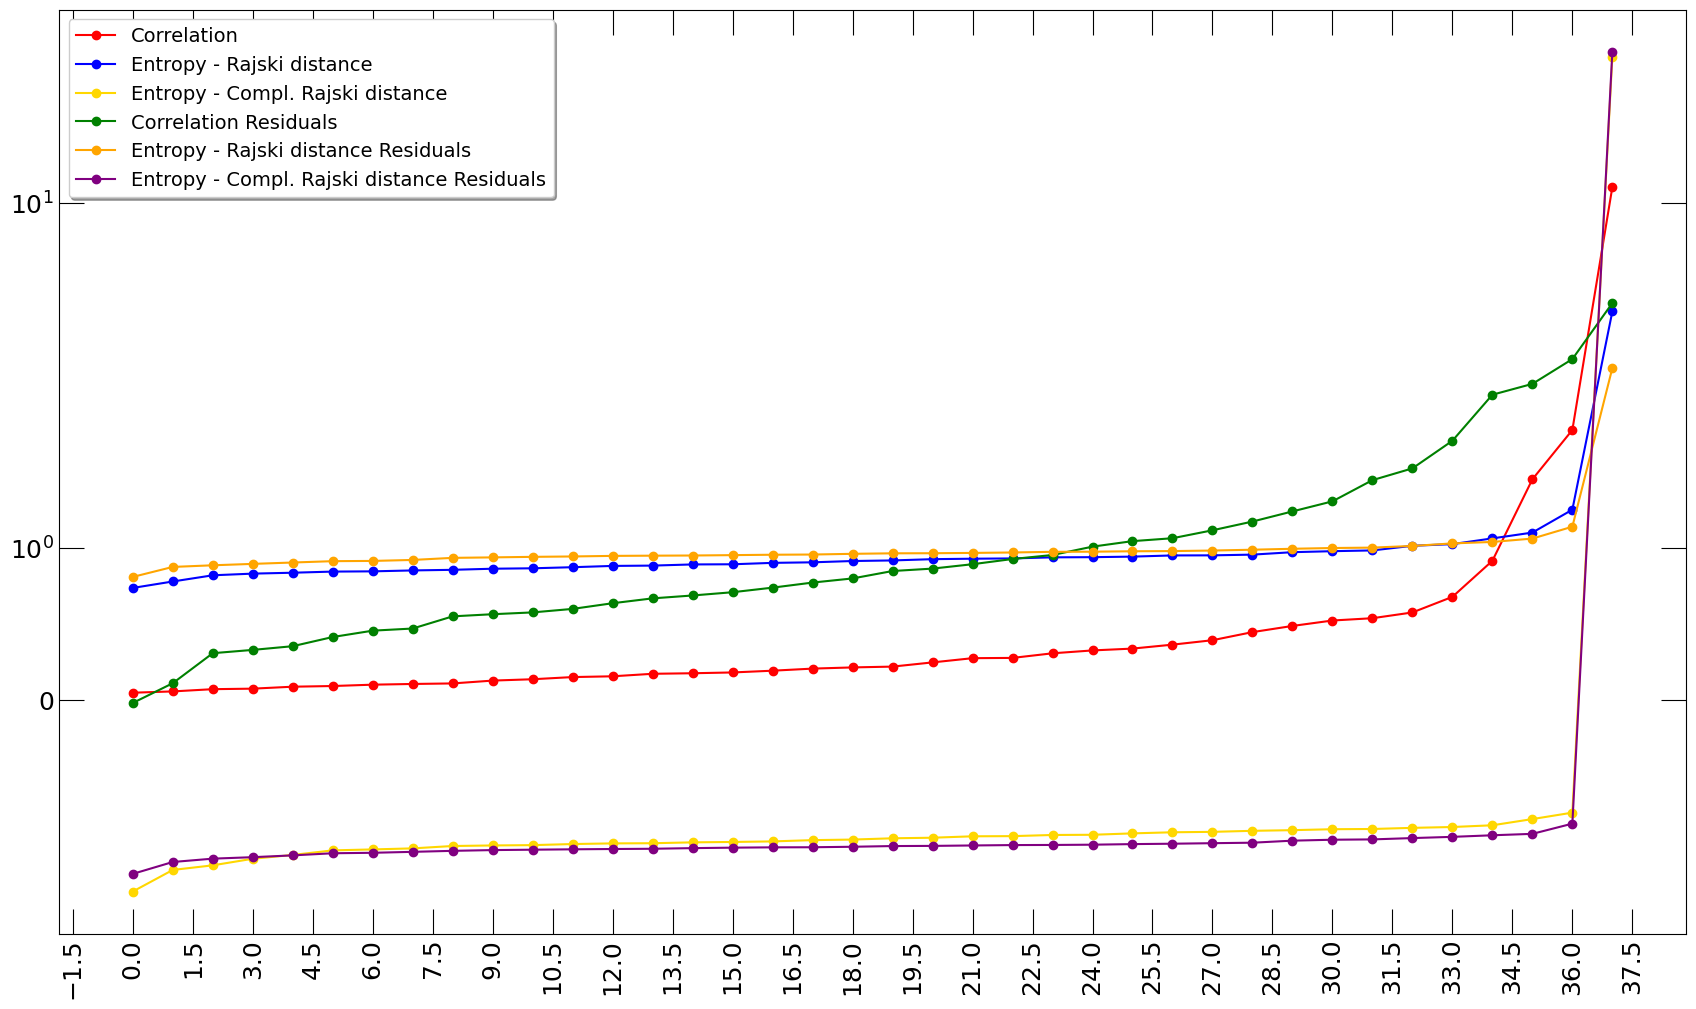

In [13]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

fig,ax = plt.subplots()
fig.set_size_inches(w = 21, h = 12)

df_8 = df_7#.tail(5)

ax.plot(df_8["eigenvalues_correlation"], color = "red", marker = "o", label = "Correlation")
ax.plot(df_8["eigenvalues_entropy"], color = "blue", marker = "o", label = "Entropy - Rajski distance")
ax.plot(df_8["eigenvalues_entropy_modified"], color = "gold", marker = "o", label = "Entropy - Compl. Rajski distance")
ax.plot(df_8["eigenvalues_correlation_res"], color = "green", marker = "o", label = "Correlation Residuals")
ax.plot(df_8["eigenvalues_entropy_res"], color = "orange", marker = "o", label = "Entropy - Rajski distance Residuals")
ax.plot(df_8["eigenvalues_entropy_modified_res"], color = "purple", marker = "o", label = "Entropy - Compl. Rajski distance Residuals")

ax.tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 18, length = 18)
ax.tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 18, length = 10)
ax.xaxis.set_major_locator(mtick.MaxNLocator(df_5.shape[0]))
ax.yaxis.set_major_locator(mtick.MaxNLocator(40))
ax.tick_params(axis = "x", labelrotation = 90)
ax.legend(fancybox = True, shadow = True, ncol = 1, fontsize = 14)

#ax.set_xscale(value = "log")
ax.set_yscale(value = "symlog")

plt.show()


## Save data

In [14]:
#df_final.to_csv("{}/df_entropy_correlation_gspc_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)), index = False)
#df_final.to_csv("{}/df_entropy_correlation_mxx_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)), index = False)
df_final.to_csv("{}/df_entropy_correlation_gdaxi_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)), index = False)

## Exploratory Data Analysis

symbol       date    CBK.DE   HEN3.DE    temp_1    temp_2  mask
0      2000-01-04  0.000000  0.000000  0.000000  0.000000     1
1      2000-01-05 -0.953624  0.139672 -0.953624  0.139672     0
2      2000-01-06  0.504810 -1.704803  0.504810 -1.704803     1
3      2000-01-07  1.114079  0.851497  1.114079  0.851497     1
4      2000-01-10 -0.058856  0.591840 -0.058856  0.591840     0


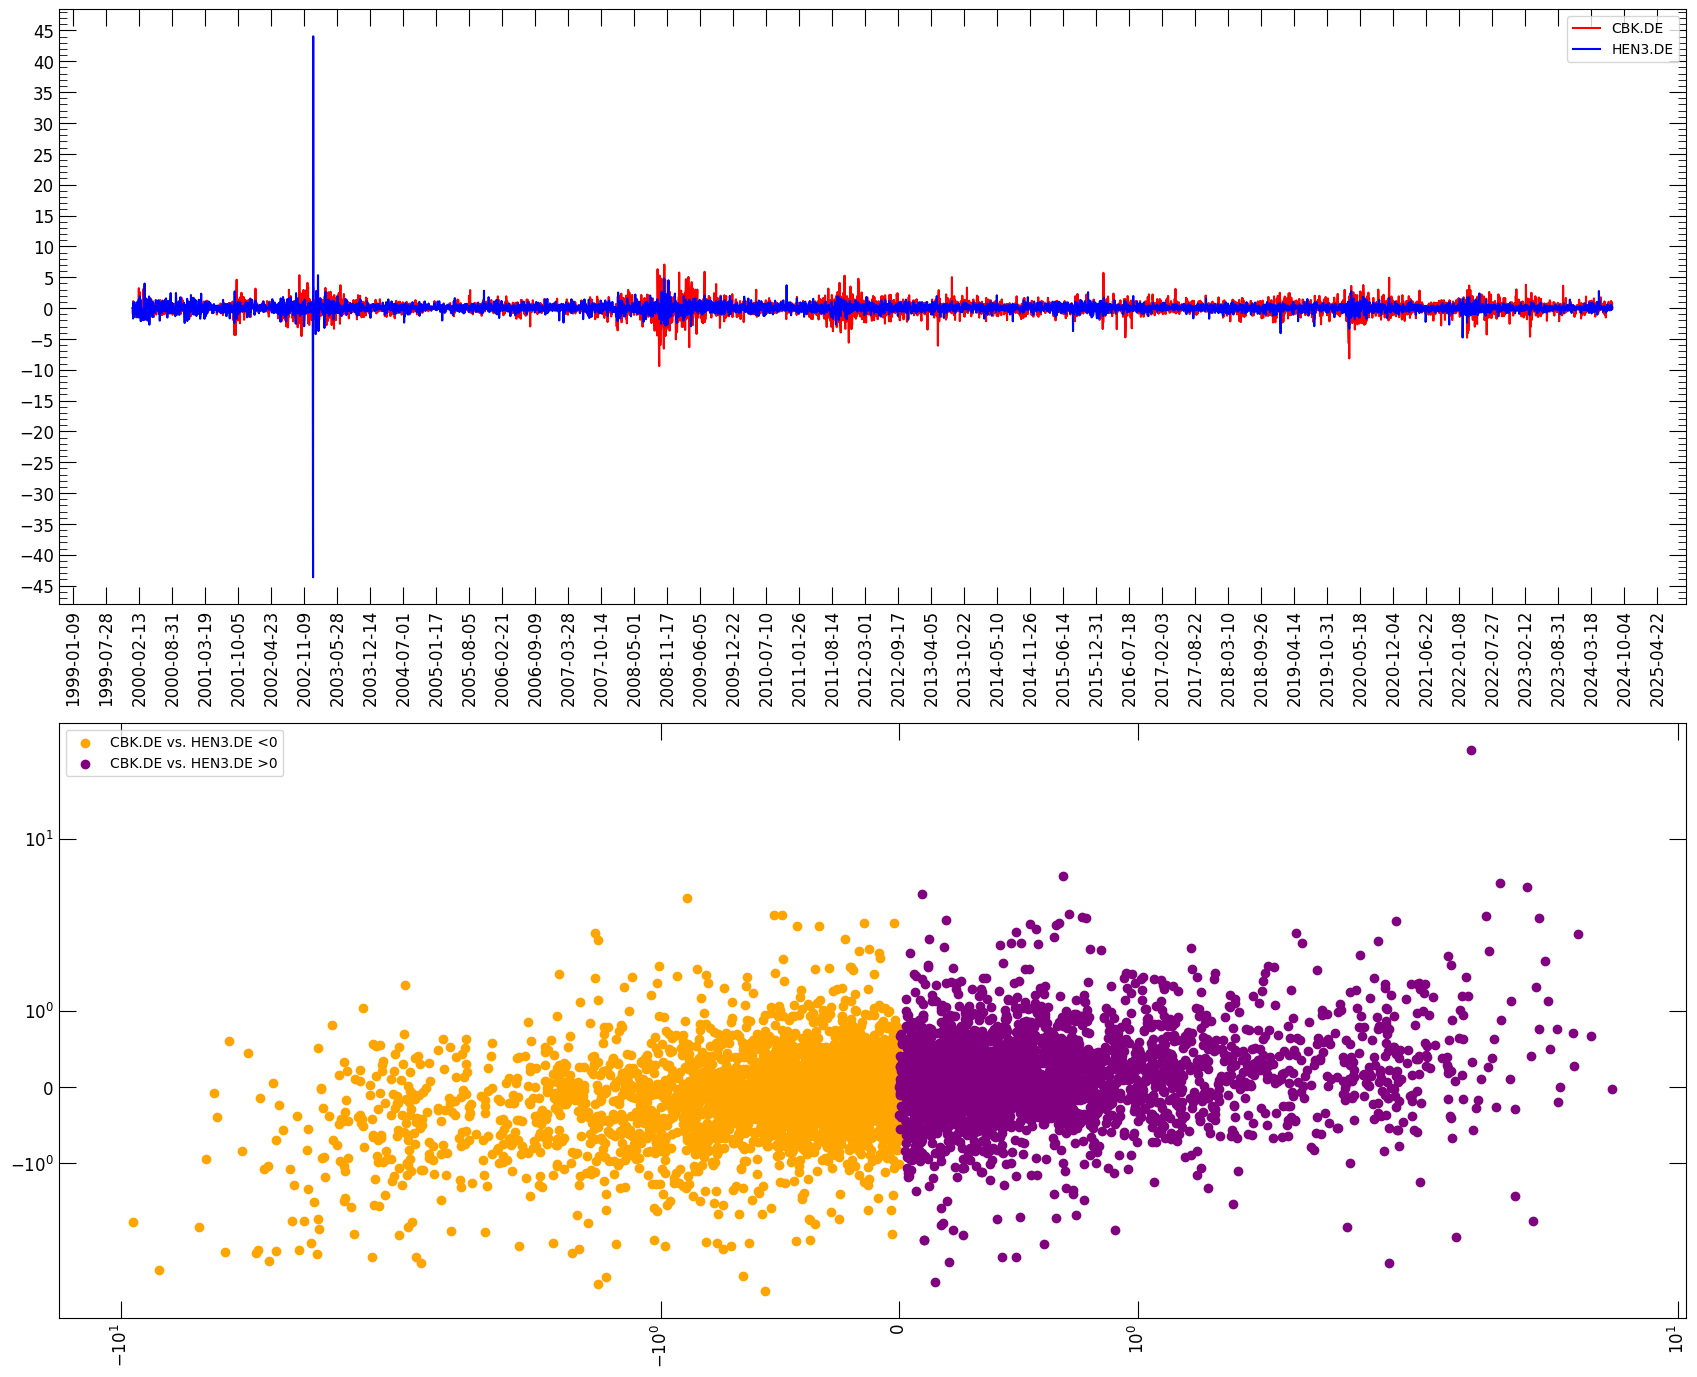

In [15]:
column_ = "z_score_log_return"

import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)

fig,ax = plt.subplots(2,1)
fig.set_size_inches(w = 21, h = 17)

df_1 = df_stock_index[df_stock_index["symbol"] == shares_pair[0]]
df_2 = df_stock_index[df_stock_index["symbol"] == shares_pair[1]]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin(shares_pair)]
        .pivot(index = "date", columns = "symbol", values = column_)
        .reset_index()
)
df_3["temp_1"] = df_3[shares_pair[0]]#.apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[shares_pair[1]]#.apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond = df_3[shares_pair[0]] < 0, other = 0)
#df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)))]
print(df_3.head())

ax[0].plot(df_1["date"], df_1[column_], color = "red", label = shares_pair[0])
ax[0].plot(df_2["date"], df_2[column_], color = "blue", label = shares_pair[1])
ax[1].scatter(df_3[df_3["mask"] == 0]["temp_1"], df_3[df_3["mask"] == 0]["temp_2"], color = "orange", label = "{} vs. {} <0".format(shares_pair[0], shares_pair[1]))
ax[1].scatter(df_3[df_3["mask"] == 1]["temp_1"], df_3[df_3["mask"] == 1]["temp_2"], color = "purple", label = "{} vs. {} >0".format(shares_pair[0], shares_pair[1]))
#ax[1].scatter(df_3[s1], df_3[s2], color = "orange", label = "{} vs. {}".format(s1, s2))

ax[0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis = "x", labelrotation = 90)
ax[0].legend()

ax[1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis = "x", labelrotation = 90)
ax[1].legend()
ax[1].set_xscale(value = "symlog")
ax[1].set_yscale(value = "symlog")

plt.show()


symbol       date    CBK.DE   HEN3.DE    temp_1    temp_2  mask
0      2000-01-04  0.000000  0.000000  0.000000  0.000000     1
1      2000-01-05 -0.953624  0.139672 -0.953624  0.139672     0
2      2000-01-06  0.504810 -1.704803  0.504810 -1.704803     1
3      2000-01-07  1.114079  0.851497  1.114079  0.851497     1
4      2000-01-10 -0.058856  0.591840 -0.058856  0.591840     0


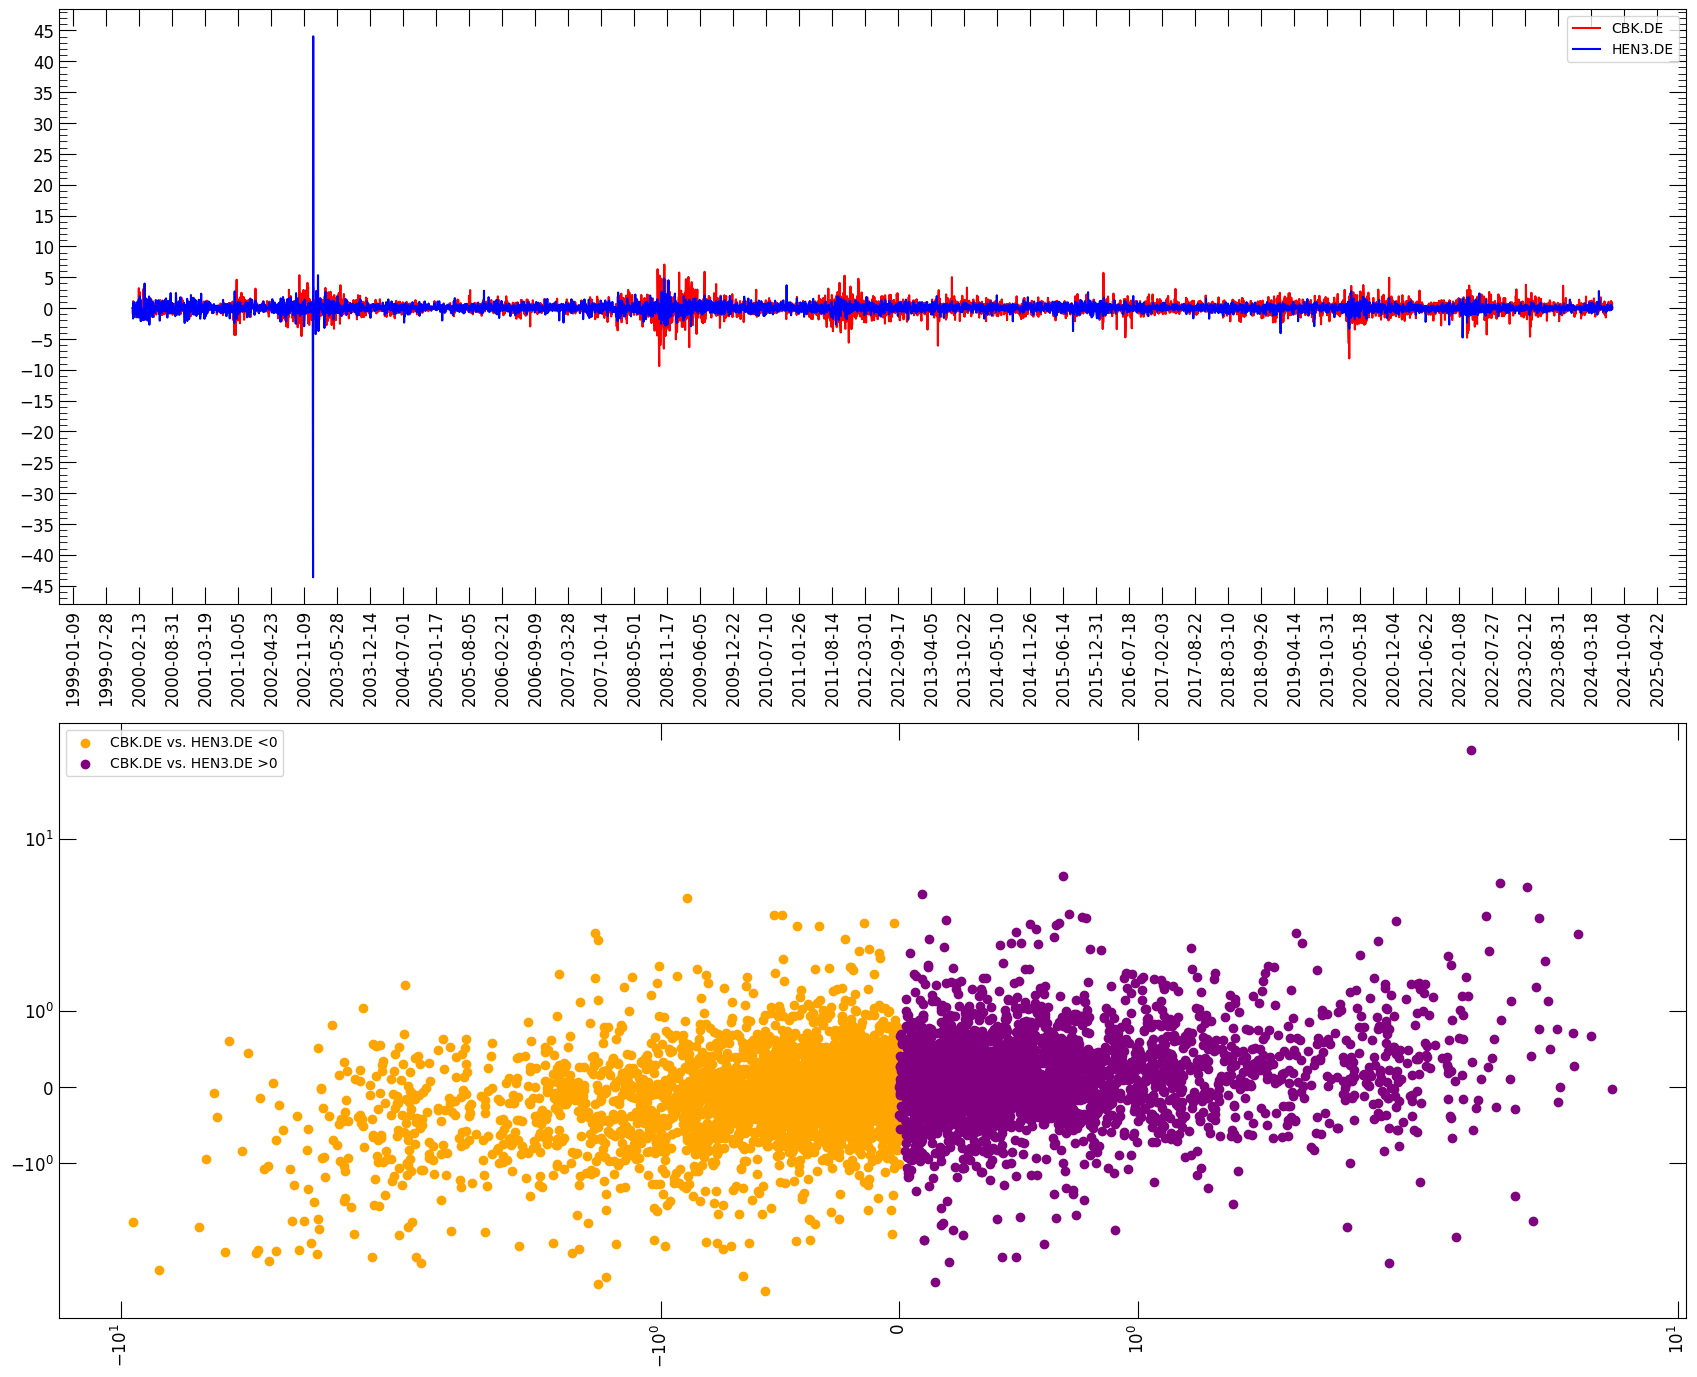

In [16]:
column_ = "z_score_log_return"

import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)

fig,ax = plt.subplots(2,1)
fig.set_size_inches(w = 21, h = 17)

df_1 = df_stock_index[df_stock_index["symbol"] == shares_pair[0]]
df_2 = df_stock_index[df_stock_index["symbol"] == shares_pair[1]]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin(shares_pair)]
        .pivot(index = "date", columns = "symbol", values = column_)
        .reset_index()
)
df_3["temp_1"] = df_3[shares_pair[0]]#.apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[shares_pair[1]]#.apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond = df_3[shares_pair[0]] < 0, other = 0)
#df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)))]
print(df_3.head())

ax[0].plot(df_1["date"], df_1[column_], color = "red", label = shares_pair[0])
ax[0].plot(df_2["date"], df_2[column_], color = "blue", label = shares_pair[1])
ax[1].scatter(df_3[df_3["mask"] == 0]["temp_1"], df_3[df_3["mask"] == 0]["temp_2"], color = "orange", label = "{} vs. {} <0".format(shares_pair[0], shares_pair[1]))
ax[1].scatter(df_3[df_3["mask"] == 1]["temp_1"], df_3[df_3["mask"] == 1]["temp_2"], color = "purple", label = "{} vs. {} >0".format(shares_pair[0], shares_pair[1]))
#ax[1].scatter(df_3[s1], df_3[s2], color = "orange", label = "{} vs. {}".format(s1, s2))

ax[0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis = "x", labelrotation = 90)
ax[0].legend()

ax[1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis = "x", labelrotation = 90)
ax[1].legend()
ax[1].set_xscale(value = "symlog")
ax[1].set_yscale(value = "symlog")

plt.show()


## Proofs

In [17]:
#p_i = N df.shape[1] #Shares
#q = 1/2
#m = 225
#step = 8
#n_i = int((1/q)*p_i)
#delta = 20
#k1_k0 = 8

#for i in range(m):
#    print(i)
#    start = i*delta
#    end = i*delta + n_i # slicing in dates between start and end through "independent" Windows of size n_i
#    returns = data filtered into start and end date

df = df_stock_index
time_delta = 240
time_step = 20

market_args_list = df[["date"]].sort_values(by = ["date"]).value_counts(sort = False).reset_index()
market_args_list["final_date"] = market_args_list["date"] + pd.DateOffset(days = time_delta)
market_args_list = (
    market_args_list
        .rename(columns = {"date" : "initial_date"})
        .iloc[::time_step]
        .reset_index()
        .drop(columns = ["count", "index"])
)
market_args_list["initial_date"] = market_args_list["initial_date"].astype(str)
market_args_list["final_date"] = market_args_list["final_date"].astype(str)
market_args_list#.values.tolist()


,initial_date,final_date
0,2000-01-04,2000-08-31
1,2000-02-01,2000-09-28
2,2000-02-29,2000-10-26
3,2000-03-28,2000-11-23
4,2000-04-27,2000-12-23
...,...,...
307,2024-03-06,2024-11-01
308,2024-04-05,2024-12-01
309,2024-05-06,2025-01-01
310,2024-06-03,2025-01-29


In [18]:
df_final_3 = []
for k in range(market_args_list.shape[0]):
    initial_date = market_args_list["initial_date"].values[k]
    final_date = market_args_list["final_date"].values[k]
    try:
        df_aux = emf.get_market_efficiency(
            df = df_stock_index,
            column_ = "z_score_log_return",
            min_bins = 10,
            precision = 12,
            log_path = log_path,
            log_filename = "log_market_efficiency_mxx",
            log_filename_entropy = "log_entropy_final_mxx",
            verbose = 1,
            tqdm_bar = True,
            market_args_list = (initial_date, final_date),
            bouchaud_filter = False,
            n = int(df_stock_index.shape[0] * 2),
            df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
            alphas = [0.01, 0.05, 0.10],
            k_max = 8,
            df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
            levels = [1, 2, 5, 10]
        )

        df_final_3.append(df_aux)

        print("Finished: {} - {}".format(initial_date, final_date))
    except:
        print("No done: {} - {}".format(initial_date, final_date))

df_final_3 = pd.concat(df_final_3)

100%|████████████████████| 378/378 [00:02<00:00, 132.74it/s]


Finished: 2000-01-04 - 2000-08-31


100%|████████████████████| 378/378 [00:02<00:00, 152.96it/s]


Finished: 2000-02-01 - 2000-09-28


100%|████████████████████| 378/378 [00:02<00:00, 143.43it/s]


Finished: 2000-02-29 - 2000-10-26


100%|████████████████████| 378/378 [00:02<00:00, 128.05it/s]


Finished: 2000-03-28 - 2000-11-23


100%|████████████████████| 406/406 [00:02<00:00, 151.02it/s]


Finished: 2000-04-27 - 2000-12-23


100%|████████████████████| 406/406 [00:02<00:00, 146.17it/s]


Finished: 2000-05-26 - 2001-01-21


100%|████████████████████| 406/406 [00:02<00:00, 144.66it/s]


Finished: 2000-06-23 - 2001-02-18


100%|████████████████████| 406/406 [00:02<00:00, 149.01it/s]


Finished: 2000-07-21 - 2001-03-18


100%|████████████████████| 435/435 [00:02<00:00, 158.65it/s]


Finished: 2000-08-18 - 2001-04-15


100%|████████████████████| 465/465 [00:02<00:00, 161.38it/s]


Finished: 2000-09-15 - 2001-05-13


100%|████████████████████| 465/465 [00:02<00:00, 159.50it/s]


Finished: 2000-10-16 - 2001-06-13


100%|████████████████████| 496/496 [00:03<00:00, 150.96it/s]


Finished: 2000-11-13 - 2001-07-11


100%|████████████████████| 496/496 [00:03<00:00, 151.83it/s]


Finished: 2000-12-11 - 2001-08-08


100%|████████████████████| 496/496 [00:03<00:00, 163.92it/s]


Finished: 2001-01-11 - 2001-09-08


100%|████████████████████| 496/496 [00:02<00:00, 175.54it/s]


Finished: 2001-02-08 - 2001-10-06


100%|████████████████████| 496/496 [00:02<00:00, 174.20it/s]


Finished: 2001-03-08 - 2001-11-03


100%|████████████████████| 496/496 [00:02<00:00, 170.81it/s]


Finished: 2001-04-05 - 2001-12-01


100%|████████████████████| 496/496 [00:02<00:00, 178.53it/s]


Finished: 2001-05-08 - 2002-01-03


100%|████████████████████| 496/496 [00:02<00:00, 178.58it/s]


Finished: 2001-06-05 - 2002-01-31


100%|████████████████████| 496/496 [00:02<00:00, 177.62it/s]


Finished: 2001-07-03 - 2002-02-28


100%|████████████████████| 496/496 [00:02<00:00, 170.45it/s]


Finished: 2001-07-31 - 2002-03-28


100%|████████████████████| 496/496 [00:02<00:00, 178.26it/s]


Finished: 2001-08-28 - 2002-04-25


100%|████████████████████| 496/496 [00:04<00:00, 113.84it/s]


Finished: 2001-09-25 - 2002-05-23


100%|████████████████████| 496/496 [00:04<00:00, 116.28it/s]


Finished: 2001-10-23 - 2002-06-20


100%|████████████████████| 496/496 [00:04<00:00, 109.45it/s]


Finished: 2001-11-20 - 2002-07-18


100%|████████████████████| 496/496 [00:04<00:00, 115.73it/s]


Finished: 2001-12-18 - 2002-08-15


100%|████████████████████| 496/496 [00:04<00:00, 116.50it/s]


Finished: 2002-01-22 - 2002-09-19


100%|████████████████████| 496/496 [00:04<00:00, 116.72it/s]


Finished: 2002-02-19 - 2002-10-17


100%|████████████████████| 496/496 [00:04<00:00, 117.16it/s]


Finished: 2002-03-19 - 2002-11-14


100%|████████████████████| 496/496 [00:04<00:00, 116.19it/s]


Finished: 2002-04-18 - 2002-12-14


100%|████████████████████| 496/496 [00:04<00:00, 114.75it/s]


Finished: 2002-05-17 - 2003-01-12


100%|████████████████████| 496/496 [00:04<00:00, 113.52it/s]


Finished: 2002-06-14 - 2003-02-09


100%|████████████████████| 496/496 [00:04<00:00, 119.52it/s]


Finished: 2002-07-12 - 2003-03-09


100%|████████████████████| 496/496 [00:04<00:00, 118.09it/s]


Finished: 2002-08-09 - 2003-04-06


100%|████████████████████| 465/465 [00:04<00:00, 109.65it/s]


Finished: 2002-09-06 - 2003-05-04


100%|████████████████████| 465/465 [00:04<00:00, 111.62it/s]


Finished: 2002-10-04 - 2003-06-01


100%|████████████████████| 465/465 [00:04<00:00, 112.43it/s]


Finished: 2002-11-01 - 2003-06-29


100%|████████████████████| 465/465 [00:04<00:00, 112.40it/s]


Finished: 2002-11-29 - 2003-07-27


100%|████████████████████| 465/465 [00:04<00:00, 114.17it/s]


Finished: 2003-01-02 - 2003-08-30


100%|████████████████████| 465/465 [00:04<00:00, 111.00it/s]


Finished: 2003-01-30 - 2003-09-27


100%|████████████████████| 465/465 [00:04<00:00, 112.13it/s]


Finished: 2003-02-27 - 2003-10-25


100%|████████████████████| 465/465 [00:04<00:00, 110.68it/s]


Finished: 2003-03-27 - 2003-11-22


100%|████████████████████| 465/465 [00:04<00:00, 105.25it/s]


Finished: 2003-04-28 - 2003-12-24


100%|████████████████████| 496/496 [00:04<00:00, 105.93it/s]


Finished: 2003-05-27 - 2004-01-22


100%|█████████████████████| 496/496 [00:05<00:00, 98.22it/s]


Finished: 2003-06-24 - 2004-02-19


100%|█████████████████████| 496/496 [00:05<00:00, 97.44it/s]


Finished: 2003-07-22 - 2004-03-18


100%|████████████████████| 496/496 [00:04<00:00, 104.75it/s]


Finished: 2003-08-19 - 2004-04-15


100%|████████████████████| 496/496 [00:04<00:00, 104.69it/s]


Finished: 2003-09-16 - 2004-05-13


100%|█████████████████████| 496/496 [00:05<00:00, 97.51it/s]


Finished: 2003-10-14 - 2004-06-10


100%|████████████████████| 496/496 [00:04<00:00, 103.16it/s]


Finished: 2003-11-11 - 2004-07-08


100%|████████████████████| 496/496 [00:04<00:00, 105.78it/s]


Finished: 2003-12-09 - 2004-08-05


100%|█████████████████████| 496/496 [00:05<00:00, 98.09it/s]


Finished: 2004-01-13 - 2004-09-09


100%|████████████████████| 496/496 [00:04<00:00, 106.55it/s]


Finished: 2004-02-10 - 2004-10-07


100%|████████████████████| 496/496 [00:04<00:00, 110.99it/s]


Finished: 2004-03-09 - 2004-11-04


100%|████████████████████| 496/496 [00:04<00:00, 104.88it/s]


Finished: 2004-04-06 - 2004-12-02


100%|████████████████████| 496/496 [00:04<00:00, 100.50it/s]


Finished: 2004-05-06 - 2005-01-01


100%|████████████████████| 496/496 [00:04<00:00, 104.22it/s]


Finished: 2004-06-03 - 2005-01-29


100%|████████████████████| 496/496 [00:04<00:00, 113.75it/s]


Finished: 2004-07-01 - 2005-02-26


100%|████████████████████| 496/496 [00:04<00:00, 101.42it/s]


Finished: 2004-07-29 - 2005-03-26


100%|████████████████████| 496/496 [00:04<00:00, 116.40it/s]


Finished: 2004-08-26 - 2005-04-23


100%|████████████████████| 496/496 [00:04<00:00, 120.05it/s]


Finished: 2004-09-23 - 2005-05-21


100%|████████████████████| 496/496 [00:04<00:00, 110.06it/s]


Finished: 2004-10-21 - 2005-06-18


100%|████████████████████| 496/496 [00:04<00:00, 112.14it/s]


Finished: 2004-11-18 - 2005-07-16


100%|████████████████████| 496/496 [00:04<00:00, 116.50it/s]


Finished: 2004-12-16 - 2005-08-13


100%|████████████████████| 496/496 [00:04<00:00, 117.07it/s]


Finished: 2005-01-17 - 2005-09-14


100%|████████████████████| 496/496 [00:04<00:00, 115.50it/s]


Finished: 2005-02-14 - 2005-10-12


100%|████████████████████| 528/528 [00:04<00:00, 117.94it/s]


Finished: 2005-03-14 - 2005-11-09


100%|████████████████████| 528/528 [00:04<00:00, 118.05it/s]


Finished: 2005-04-13 - 2005-12-09


100%|████████████████████| 528/528 [00:05<00:00, 103.04it/s]


Finished: 2005-05-11 - 2006-01-06


100%|████████████████████| 528/528 [00:04<00:00, 117.06it/s]


Finished: 2005-06-08 - 2006-02-03


100%|████████████████████| 528/528 [00:04<00:00, 121.75it/s]


Finished: 2005-07-06 - 2006-03-03


100%|████████████████████| 528/528 [00:04<00:00, 110.73it/s]


Finished: 2005-08-03 - 2006-03-31


100%|████████████████████| 528/528 [00:04<00:00, 118.80it/s]


Finished: 2005-08-31 - 2006-04-28


100%|████████████████████| 528/528 [00:04<00:00, 118.30it/s]


Finished: 2005-09-28 - 2006-05-26


100%|████████████████████| 528/528 [00:04<00:00, 119.79it/s]


Finished: 2005-10-26 - 2006-06-23


100%|████████████████████| 528/528 [00:04<00:00, 117.58it/s]


Finished: 2005-11-23 - 2006-07-21


100%|████████████████████| 528/528 [00:04<00:00, 123.92it/s]


Finished: 2005-12-21 - 2006-08-18


100%|████████████████████| 528/528 [00:04<00:00, 119.99it/s]


Finished: 2006-01-19 - 2006-09-16


100%|████████████████████| 528/528 [00:04<00:00, 119.67it/s]


Finished: 2006-02-16 - 2006-10-14


100%|████████████████████| 528/528 [00:04<00:00, 121.59it/s]


Finished: 2006-03-16 - 2006-11-11


100%|████████████████████| 528/528 [00:04<00:00, 120.82it/s]


Finished: 2006-04-13 - 2006-12-09


100%|████████████████████| 528/528 [00:04<00:00, 113.08it/s]


Finished: 2006-05-16 - 2007-01-11


100%|████████████████████| 528/528 [00:04<00:00, 112.94it/s]


Finished: 2006-06-13 - 2007-02-08


100%|████████████████████| 528/528 [00:04<00:00, 106.77it/s]


Finished: 2006-07-11 - 2007-03-08


100%|████████████████████| 528/528 [00:04<00:00, 112.01it/s]


Finished: 2006-08-08 - 2007-04-05


100%|████████████████████| 528/528 [00:04<00:00, 106.24it/s]


Finished: 2006-09-05 - 2007-05-03


100%|█████████████████████| 561/561 [00:05<00:00, 98.75it/s]


Finished: 2006-10-03 - 2007-05-31


100%|████████████████████| 595/595 [00:05<00:00, 105.64it/s]


Finished: 2006-10-31 - 2007-06-28


100%|█████████████████████| 595/595 [00:06<00:00, 98.07it/s]


Finished: 2006-11-28 - 2007-07-26


100%|████████████████████| 595/595 [00:05<00:00, 110.20it/s]


Finished: 2006-12-28 - 2007-08-25


100%|████████████████████| 595/595 [00:04<00:00, 123.03it/s]


Finished: 2007-01-26 - 2007-09-23


100%|████████████████████| 595/595 [00:04<00:00, 121.09it/s]


Finished: 2007-02-23 - 2007-10-21


100%|████████████████████| 595/595 [00:04<00:00, 122.42it/s]


Finished: 2007-03-23 - 2007-11-18


100%|████████████████████| 595/595 [00:05<00:00, 100.48it/s]


Finished: 2007-04-24 - 2007-12-20


100%|████████████████████| 595/595 [00:04<00:00, 119.46it/s]


Finished: 2007-05-23 - 2008-01-18


100%|████████████████████| 595/595 [00:04<00:00, 122.70it/s]


Finished: 2007-06-21 - 2008-02-16


100%|████████████████████| 595/595 [00:04<00:00, 121.84it/s]


Finished: 2007-07-19 - 2008-03-15


100%|████████████████████| 595/595 [00:05<00:00, 118.24it/s]


Finished: 2007-08-16 - 2008-04-12


100%|████████████████████| 595/595 [00:05<00:00, 117.57it/s]


Finished: 2007-09-13 - 2008-05-10


100%|████████████████████| 595/595 [00:04<00:00, 122.03it/s]


Finished: 2007-10-11 - 2008-06-07


100%|████████████████████| 595/595 [00:04<00:00, 119.55it/s]


Finished: 2007-11-08 - 2008-07-05


100%|████████████████████| 595/595 [00:04<00:00, 119.82it/s]


Finished: 2007-12-06 - 2008-08-02


100%|████████████████████| 595/595 [00:04<00:00, 122.64it/s]


Finished: 2008-01-10 - 2008-09-06


100%|████████████████████| 595/595 [00:04<00:00, 125.86it/s]


Finished: 2008-02-07 - 2008-10-04


100%|████████████████████| 561/561 [00:04<00:00, 116.79it/s]


Finished: 2008-03-06 - 2008-11-01


100%|████████████████████| 561/561 [00:04<00:00, 120.35it/s]


Finished: 2008-04-07 - 2008-12-03


100%|████████████████████| 561/561 [00:04<00:00, 120.03it/s]


Finished: 2008-05-06 - 2009-01-01


100%|████████████████████| 561/561 [00:04<00:00, 114.09it/s]


Finished: 2008-06-03 - 2009-01-29


100%|████████████████████| 561/561 [00:04<00:00, 121.29it/s]


Finished: 2008-07-01 - 2009-02-26


100%|████████████████████| 561/561 [00:04<00:00, 118.25it/s]


Finished: 2008-07-29 - 2009-03-26


100%|████████████████████| 561/561 [00:04<00:00, 116.05it/s]


Finished: 2008-08-26 - 2009-04-23


100%|████████████████████| 561/561 [00:04<00:00, 117.10it/s]


Finished: 2008-09-23 - 2009-05-21


100%|████████████████████| 561/561 [00:04<00:00, 120.01it/s]


Finished: 2008-10-21 - 2009-06-18


100%|████████████████████| 595/595 [00:05<00:00, 117.36it/s]


Finished: 2008-11-18 - 2009-07-16


100%|████████████████████| 595/595 [00:04<00:00, 124.05it/s]


Finished: 2008-12-16 - 2009-08-13


100%|████████████████████| 595/595 [00:04<00:00, 123.34it/s]


Finished: 2009-01-20 - 2009-09-17


100%|████████████████████| 595/595 [00:05<00:00, 117.55it/s]


Finished: 2009-02-17 - 2009-10-15


100%|████████████████████| 595/595 [00:04<00:00, 126.69it/s]


Finished: 2009-03-17 - 2009-11-12


100%|████████████████████| 595/595 [00:04<00:00, 124.94it/s]


Finished: 2009-04-16 - 2009-12-12


100%|████████████████████| 595/595 [00:05<00:00, 116.74it/s]


Finished: 2009-05-15 - 2010-01-10


100%|████████████████████| 595/595 [00:04<00:00, 125.41it/s]


Finished: 2009-06-12 - 2010-02-07


100%|████████████████████| 595/595 [00:04<00:00, 124.02it/s]


Finished: 2009-07-10 - 2010-03-07


100%|████████████████████| 595/595 [00:05<00:00, 116.00it/s]


Finished: 2009-08-07 - 2010-04-04


100%|████████████████████| 595/595 [00:04<00:00, 125.31it/s]


Finished: 2009-09-04 - 2010-05-02


100%|████████████████████| 595/595 [00:04<00:00, 123.93it/s]


Finished: 2009-10-02 - 2010-05-30


100%|████████████████████| 595/595 [00:05<00:00, 118.68it/s]


Finished: 2009-10-30 - 2010-06-27


100%|████████████████████| 595/595 [00:04<00:00, 126.03it/s]


Finished: 2009-11-27 - 2010-07-25


100%|████████████████████| 595/595 [00:05<00:00, 115.49it/s]


Finished: 2009-12-29 - 2010-08-26


100%|████████████████████| 630/630 [00:05<00:00, 118.26it/s]


Finished: 2010-01-28 - 2010-09-25


100%|████████████████████| 630/630 [00:05<00:00, 121.34it/s]


Finished: 2010-02-25 - 2010-10-23


100%|████████████████████| 630/630 [00:05<00:00, 120.19it/s]


Finished: 2010-03-25 - 2010-11-20


100%|████████████████████| 630/630 [00:05<00:00, 110.03it/s]


Finished: 2010-04-26 - 2010-12-22


100%|████████████████████| 630/630 [00:05<00:00, 125.46it/s]


Finished: 2010-05-24 - 2011-01-19


100%|████████████████████| 630/630 [00:05<00:00, 125.83it/s]


Finished: 2010-06-21 - 2011-02-16


100%|████████████████████| 630/630 [00:05<00:00, 122.50it/s]


Finished: 2010-07-19 - 2011-03-16


100%|████████████████████| 630/630 [00:04<00:00, 128.64it/s]


Finished: 2010-08-16 - 2011-04-13


100%|████████████████████| 630/630 [00:05<00:00, 122.97it/s]


Finished: 2010-09-13 - 2011-05-11


100%|████████████████████| 630/630 [00:05<00:00, 118.09it/s]


Finished: 2010-10-11 - 2011-06-08


100%|████████████████████| 630/630 [00:04<00:00, 128.37it/s]


Finished: 2010-11-08 - 2011-07-06


100%|████████████████████| 630/630 [00:04<00:00, 128.99it/s]


Finished: 2010-12-06 - 2011-08-03


100%|████████████████████| 630/630 [00:05<00:00, 125.53it/s]


Finished: 2011-01-05 - 2011-09-02


100%|████████████████████| 630/630 [00:04<00:00, 126.62it/s]


Finished: 2011-02-02 - 2011-09-30


100%|████████████████████| 630/630 [00:05<00:00, 124.00it/s]


Finished: 2011-03-02 - 2011-10-28


100%|████████████████████| 630/630 [00:05<00:00, 123.27it/s]


Finished: 2011-03-30 - 2011-11-25


100%|████████████████████| 630/630 [00:04<00:00, 128.48it/s]


Finished: 2011-04-29 - 2011-12-25


100%|████████████████████| 630/630 [00:05<00:00, 120.67it/s]


Finished: 2011-05-27 - 2012-01-22


100%|████████████████████| 630/630 [00:05<00:00, 123.10it/s]


Finished: 2011-06-24 - 2012-02-19


100%|████████████████████| 630/630 [00:04<00:00, 127.16it/s]


Finished: 2011-07-22 - 2012-03-18


100%|████████████████████| 630/630 [00:05<00:00, 125.14it/s]


Finished: 2011-08-19 - 2012-04-15


100%|████████████████████| 630/630 [00:04<00:00, 126.32it/s]


Finished: 2011-09-16 - 2012-05-13


100%|████████████████████| 630/630 [00:04<00:00, 127.93it/s]


Finished: 2011-10-17 - 2012-06-13


100%|████████████████████| 630/630 [00:05<00:00, 124.07it/s]


Finished: 2011-11-14 - 2012-07-11


100%|████████████████████| 630/630 [00:05<00:00, 122.39it/s]


Finished: 2011-12-12 - 2012-08-08


100%|████████████████████| 630/630 [00:05<00:00, 105.03it/s]


Finished: 2012-01-10 - 2012-09-06


100%|████████████████████| 630/630 [00:05<00:00, 109.58it/s]


Finished: 2012-02-07 - 2012-10-04


100%|████████████████████| 630/630 [00:05<00:00, 110.05it/s]


Finished: 2012-03-06 - 2012-11-01


100%|████████████████████| 630/630 [00:05<00:00, 112.99it/s]


Finished: 2012-04-03 - 2012-11-29


100%|████████████████████| 630/630 [00:05<00:00, 113.20it/s]


Finished: 2012-05-04 - 2012-12-30


100%|████████████████████| 630/630 [00:05<00:00, 116.42it/s]


Finished: 2012-06-01 - 2013-01-27


100%|████████████████████| 630/630 [00:05<00:00, 123.78it/s]


Finished: 2012-06-29 - 2013-02-24


100%|████████████████████| 630/630 [00:05<00:00, 105.45it/s]


Finished: 2012-07-27 - 2013-03-24


100%|████████████████████| 630/630 [00:06<00:00, 100.64it/s]


Finished: 2012-08-24 - 2013-04-21


100%|████████████████████| 630/630 [00:05<00:00, 105.74it/s]


Finished: 2012-09-21 - 2013-05-19


100%|████████████████████| 630/630 [00:05<00:00, 119.92it/s]


Finished: 2012-10-22 - 2013-06-19


100%|████████████████████| 630/630 [00:05<00:00, 120.21it/s]


Finished: 2012-11-19 - 2013-07-17


100%|████████████████████| 630/630 [00:05<00:00, 121.63it/s]


Finished: 2012-12-17 - 2013-08-14


100%|████████████████████| 630/630 [00:05<00:00, 117.29it/s]


Finished: 2013-01-21 - 2013-09-18


100%|████████████████████| 630/630 [00:05<00:00, 118.37it/s]


Finished: 2013-02-18 - 2013-10-16


100%|████████████████████| 630/630 [00:05<00:00, 117.71it/s]


Finished: 2013-03-18 - 2013-11-13


100%|████████████████████| 666/666 [00:05<00:00, 118.42it/s]


Finished: 2013-04-17 - 2013-12-13


100%|████████████████████| 666/666 [00:05<00:00, 122.88it/s]


Finished: 2013-05-16 - 2014-01-11


100%|████████████████████| 666/666 [00:05<00:00, 113.49it/s]


Finished: 2013-06-13 - 2014-02-08


100%|████████████████████| 666/666 [00:05<00:00, 111.14it/s]


Finished: 2013-07-11 - 2014-03-08


100%|████████████████████| 666/666 [00:05<00:00, 119.82it/s]


Finished: 2013-08-08 - 2014-04-05


100%|████████████████████| 666/666 [00:05<00:00, 120.97it/s]


Finished: 2013-09-05 - 2014-05-03


100%|████████████████████| 666/666 [00:05<00:00, 121.09it/s]


Finished: 2013-10-04 - 2014-06-01


100%|████████████████████| 666/666 [00:05<00:00, 119.97it/s]


Finished: 2013-11-01 - 2014-06-29


100%|████████████████████| 666/666 [00:05<00:00, 120.14it/s]


Finished: 2013-11-29 - 2014-07-27


100%|████████████████████| 666/666 [00:05<00:00, 116.22it/s]


Finished: 2014-01-03 - 2014-08-31


100%|████████████████████| 666/666 [00:05<00:00, 116.61it/s]


Finished: 2014-01-31 - 2014-09-28


100%|████████████████████| 666/666 [00:06<00:00, 101.93it/s]


Finished: 2014-02-28 - 2014-10-26


100%|████████████████████| 666/666 [00:05<00:00, 117.55it/s]


Finished: 2014-03-28 - 2014-11-23


100%|████████████████████| 666/666 [00:05<00:00, 121.70it/s]


Finished: 2014-04-29 - 2014-12-25


100%|████████████████████| 666/666 [00:05<00:00, 115.67it/s]


Finished: 2014-05-28 - 2015-01-23


100%|████████████████████| 666/666 [00:06<00:00, 108.35it/s]


Finished: 2014-06-25 - 2015-02-20


100%|████████████████████| 703/703 [00:05<00:00, 122.22it/s]


Finished: 2014-07-23 - 2015-03-20


100%|████████████████████| 703/703 [00:05<00:00, 125.13it/s]


Finished: 2014-08-20 - 2015-04-17


100%|████████████████████| 703/703 [00:05<00:00, 125.42it/s]


Finished: 2014-09-17 - 2015-05-15


100%|████████████████████| 703/703 [00:05<00:00, 118.81it/s]


Finished: 2014-10-16 - 2015-06-13


100%|████████████████████| 703/703 [00:06<00:00, 104.13it/s]


Finished: 2014-11-13 - 2015-07-11


100%|████████████████████| 703/703 [00:06<00:00, 104.52it/s]


Finished: 2014-12-11 - 2015-08-08


100%|████████████████████| 703/703 [00:06<00:00, 116.90it/s]


Finished: 2015-01-15 - 2015-09-12


100%|████████████████████| 703/703 [00:05<00:00, 122.88it/s]


Finished: 2015-02-12 - 2015-10-10


100%|████████████████████| 703/703 [00:05<00:00, 119.75it/s]


Finished: 2015-03-12 - 2015-11-07


100%|████████████████████| 703/703 [00:06<00:00, 110.05it/s]


Finished: 2015-04-13 - 2015-12-09


100%|████████████████████| 703/703 [00:05<00:00, 124.56it/s]


Finished: 2015-05-12 - 2016-01-07


100%|████████████████████| 703/703 [00:05<00:00, 121.21it/s]


Finished: 2015-06-10 - 2016-02-05


100%|████████████████████| 741/741 [00:06<00:00, 123.18it/s]


Finished: 2015-07-08 - 2016-03-04


100%|████████████████████| 741/741 [00:05<00:00, 124.10it/s]


Finished: 2015-08-05 - 2016-04-01


100%|████████████████████| 741/741 [00:06<00:00, 113.92it/s]


Finished: 2015-09-02 - 2016-04-29


100%|████████████████████| 741/741 [00:06<00:00, 113.19it/s]


Finished: 2015-09-30 - 2016-05-27


100%|████████████████████| 741/741 [00:06<00:00, 118.94it/s]


Finished: 2015-10-28 - 2016-06-24


100%|████████████████████| 741/741 [00:06<00:00, 112.04it/s]


Finished: 2015-11-25 - 2016-07-22


100%|████████████████████| 741/741 [00:06<00:00, 117.61it/s]


Finished: 2015-12-23 - 2016-08-19


100%|████████████████████| 741/741 [00:05<00:00, 123.80it/s]


Finished: 2016-01-26 - 2016-09-22


100%|████████████████████| 741/741 [00:06<00:00, 113.55it/s]


Finished: 2016-02-23 - 2016-10-20


100%|████████████████████| 741/741 [00:06<00:00, 120.96it/s]


Finished: 2016-03-22 - 2016-11-17


100%|████████████████████| 741/741 [00:06<00:00, 120.17it/s]


Finished: 2016-04-21 - 2016-12-17


100%|████████████████████| 741/741 [00:06<00:00, 120.82it/s]


Finished: 2016-05-20 - 2017-01-15


100%|█████████████████████| 741/741 [00:07<00:00, 99.61it/s]


Finished: 2016-06-17 - 2017-02-12


100%|████████████████████| 741/741 [00:06<00:00, 121.45it/s]


Finished: 2016-07-15 - 2017-03-12


100%|████████████████████| 741/741 [00:06<00:00, 116.82it/s]


Finished: 2016-08-12 - 2017-04-09


100%|████████████████████| 741/741 [00:06<00:00, 121.76it/s]


Finished: 2016-09-09 - 2017-05-07


100%|████████████████████| 741/741 [00:06<00:00, 118.15it/s]


Finished: 2016-10-10 - 2017-06-07


100%|████████████████████| 741/741 [00:06<00:00, 122.51it/s]


Finished: 2016-11-07 - 2017-07-05


100%|████████████████████| 741/741 [00:06<00:00, 119.84it/s]


Finished: 2016-12-05 - 2017-08-02


100%|████████████████████| 741/741 [00:06<00:00, 119.58it/s]


Finished: 2017-01-03 - 2017-08-31


100%|████████████████████| 741/741 [00:06<00:00, 119.57it/s]


Finished: 2017-01-31 - 2017-09-28


100%|████████████████████| 741/741 [00:06<00:00, 122.88it/s]


Finished: 2017-02-28 - 2017-10-26


100%|████████████████████| 741/741 [00:06<00:00, 121.43it/s]


Finished: 2017-03-28 - 2017-11-23


100%|████████████████████| 741/741 [00:06<00:00, 122.30it/s]


Finished: 2017-04-27 - 2017-12-23


100%|████████████████████| 741/741 [00:06<00:00, 120.29it/s]


Finished: 2017-05-26 - 2018-01-21


100%|████████████████████| 741/741 [00:06<00:00, 121.70it/s]


Finished: 2017-06-26 - 2018-02-21


100%|████████████████████| 741/741 [00:06<00:00, 118.67it/s]


Finished: 2017-07-24 - 2018-03-21


100%|████████████████████| 741/741 [00:06<00:00, 122.52it/s]


Finished: 2017-08-21 - 2018-04-18


100%|████████████████████| 741/741 [00:06<00:00, 115.41it/s]


Finished: 2017-09-18 - 2018-05-16


100%|████████████████████| 741/741 [00:06<00:00, 122.43it/s]


Finished: 2017-10-17 - 2018-06-14


100%|████████████████████| 741/741 [00:06<00:00, 112.27it/s]


Finished: 2017-11-15 - 2018-07-13


100%|████████████████████| 741/741 [00:06<00:00, 119.72it/s]


Finished: 2017-12-13 - 2018-08-10


100%|████████████████████| 780/780 [00:06<00:00, 120.72it/s]


Finished: 2018-01-15 - 2018-09-12


100%|████████████████████| 780/780 [00:06<00:00, 122.36it/s]


Finished: 2018-02-12 - 2018-10-10


100%|████████████████████| 780/780 [00:06<00:00, 116.26it/s]


Finished: 2018-03-12 - 2018-11-07


100%|█████████████████████| 780/780 [00:08<00:00, 90.92it/s]


Finished: 2018-04-11 - 2018-12-07


100%|█████████████████████| 780/780 [00:07<00:00, 98.64it/s]


Finished: 2018-05-10 - 2019-01-05


100%|████████████████████| 780/780 [00:07<00:00, 106.24it/s]


Finished: 2018-06-08 - 2019-02-03


100%|████████████████████| 780/780 [00:07<00:00, 106.51it/s]


Finished: 2018-07-06 - 2019-03-03


100%|████████████████████| 820/820 [00:07<00:00, 116.60it/s]


Finished: 2018-08-03 - 2019-03-31


100%|████████████████████| 820/820 [00:07<00:00, 104.55it/s]


Finished: 2018-08-31 - 2019-04-28


100%|████████████████████| 820/820 [00:07<00:00, 113.64it/s]


Finished: 2018-09-28 - 2019-05-26


100%|████████████████████| 820/820 [00:06<00:00, 118.34it/s]


Finished: 2018-10-29 - 2019-06-26


100%|████████████████████| 820/820 [00:06<00:00, 123.68it/s]


Finished: 2018-11-26 - 2019-07-24


100%|████████████████████| 820/820 [00:06<00:00, 122.99it/s]


Finished: 2018-12-27 - 2019-08-24


100%|████████████████████| 820/820 [00:06<00:00, 121.22it/s]


Finished: 2019-01-28 - 2019-09-25


100%|████████████████████| 820/820 [00:06<00:00, 120.74it/s]


Finished: 2019-02-25 - 2019-10-23


100%|████████████████████| 820/820 [00:06<00:00, 121.83it/s]


Finished: 2019-03-25 - 2019-11-20


100%|████████████████████| 820/820 [00:06<00:00, 118.96it/s]


Finished: 2019-04-24 - 2019-12-20


100%|████████████████████| 820/820 [00:06<00:00, 123.93it/s]


Finished: 2019-05-23 - 2020-01-18


100%|████████████████████| 820/820 [00:06<00:00, 120.73it/s]


Finished: 2019-06-21 - 2020-02-16


100%|████████████████████| 820/820 [00:06<00:00, 119.99it/s]


Finished: 2019-07-19 - 2020-03-15


100%|████████████████████| 820/820 [00:06<00:00, 121.16it/s]


Finished: 2019-08-16 - 2020-04-12


100%|████████████████████| 820/820 [00:06<00:00, 124.56it/s]


Finished: 2019-09-13 - 2020-05-10


100%|████████████████████| 820/820 [00:06<00:00, 124.00it/s]


Finished: 2019-10-14 - 2020-06-10


100%|████████████████████| 820/820 [00:06<00:00, 119.99it/s]


Finished: 2019-11-11 - 2020-07-08


100%|████████████████████| 820/820 [00:06<00:00, 126.66it/s]


Finished: 2019-12-09 - 2020-08-05


100%|████████████████████| 820/820 [00:06<00:00, 125.73it/s]


Finished: 2020-01-13 - 2020-09-09


100%|████████████████████| 820/820 [00:06<00:00, 124.92it/s]


Finished: 2020-02-10 - 2020-10-07


100%|████████████████████| 820/820 [00:06<00:00, 120.34it/s]


Finished: 2020-03-09 - 2020-11-04


100%|████████████████████| 820/820 [00:07<00:00, 115.71it/s]


Finished: 2020-04-06 - 2020-12-02


100%|████████████████████| 820/820 [00:06<00:00, 126.63it/s]


Finished: 2020-05-07 - 2021-01-02


100%|████████████████████| 820/820 [00:06<00:00, 120.82it/s]


Finished: 2020-06-05 - 2021-01-31


100%|████████████████████| 861/861 [00:06<00:00, 127.06it/s]


Finished: 2020-07-03 - 2021-02-28


100%|████████████████████| 861/861 [00:07<00:00, 122.55it/s]


Finished: 2020-07-31 - 2021-03-28


100%|████████████████████| 861/861 [00:06<00:00, 126.58it/s]


Finished: 2020-08-28 - 2021-04-25


100%|████████████████████| 861/861 [00:06<00:00, 125.78it/s]


Finished: 2020-09-25 - 2021-05-23


100%|████████████████████| 861/861 [00:06<00:00, 125.94it/s]


Finished: 2020-10-23 - 2021-06-20


100%|████████████████████| 861/861 [00:06<00:00, 125.20it/s]


Finished: 2020-11-20 - 2021-07-18


100%|████████████████████| 861/861 [00:06<00:00, 125.33it/s]


Finished: 2020-12-18 - 2021-08-15


100%|████████████████████| 861/861 [00:07<00:00, 110.73it/s]


Finished: 2021-01-21 - 2021-09-18


100%|████████████████████| 861/861 [00:08<00:00, 102.70it/s]


Finished: 2021-02-18 - 2021-10-16


100%|████████████████████| 861/861 [00:08<00:00, 104.00it/s]


Finished: 2021-03-18 - 2021-11-13


100%|████████████████████| 861/861 [00:07<00:00, 108.39it/s]


Finished: 2021-04-19 - 2021-12-15


100%|████████████████████| 861/861 [00:07<00:00, 117.99it/s]


Finished: 2021-05-17 - 2022-01-12


100%|████████████████████| 861/861 [00:07<00:00, 113.99it/s]


Finished: 2021-06-15 - 2022-02-10


100%|████████████████████| 861/861 [00:07<00:00, 110.63it/s]


Finished: 2021-07-13 - 2022-03-10


100%|█████████████████████| 861/861 [00:08<00:00, 96.46it/s]


Finished: 2021-08-10 - 2022-04-07


100%|████████████████████| 861/861 [00:07<00:00, 107.67it/s]


Finished: 2021-09-07 - 2022-05-05


100%|████████████████████| 903/903 [00:07<00:00, 122.07it/s]


Finished: 2021-10-05 - 2022-06-02


100%|████████████████████| 903/903 [00:07<00:00, 127.08it/s]


Finished: 2021-11-02 - 2022-06-30


100%|████████████████████| 903/903 [00:07<00:00, 117.85it/s]


Finished: 2021-11-30 - 2022-07-28


100%|████████████████████| 903/903 [00:08<00:00, 103.00it/s]


Finished: 2021-12-29 - 2022-08-26


100%|████████████████████| 903/903 [00:07<00:00, 124.95it/s]


Finished: 2022-01-27 - 2022-09-24


100%|████████████████████| 903/903 [00:07<00:00, 118.43it/s]


Finished: 2022-02-24 - 2022-10-22


100%|████████████████████| 903/903 [00:07<00:00, 125.24it/s]


Finished: 2022-03-24 - 2022-11-19


100%|████████████████████| 903/903 [00:07<00:00, 123.39it/s]


Finished: 2022-04-25 - 2022-12-21


100%|████████████████████| 903/903 [00:07<00:00, 123.41it/s]


Finished: 2022-05-23 - 2023-01-18


100%|████████████████████| 903/903 [00:07<00:00, 119.37it/s]


Finished: 2022-06-20 - 2023-02-15


100%|████████████████████| 946/946 [00:08<00:00, 112.87it/s]


Finished: 2022-07-18 - 2023-03-15


100%|████████████████████| 946/946 [00:08<00:00, 110.48it/s]


Finished: 2022-08-15 - 2023-04-12


100%|████████████████████| 946/946 [00:08<00:00, 110.27it/s]


Finished: 2022-09-12 - 2023-05-10


100%|████████████████████| 946/946 [00:08<00:00, 105.84it/s]


Finished: 2022-10-10 - 2023-06-07


100%|████████████████████| 946/946 [00:07<00:00, 125.61it/s]


Finished: 2022-11-07 - 2023-07-05


100%|████████████████████| 946/946 [00:07<00:00, 124.17it/s]


Finished: 2022-12-05 - 2023-08-02


100%|████████████████████| 946/946 [00:07<00:00, 124.30it/s]


Finished: 2023-01-03 - 2023-08-31


100%|████████████████████| 946/946 [00:07<00:00, 123.18it/s]


Finished: 2023-01-31 - 2023-09-28


100%|████████████████████| 946/946 [00:07<00:00, 125.69it/s]


Finished: 2023-02-28 - 2023-10-26


100%|████████████████████| 946/946 [00:07<00:00, 122.75it/s]


Finished: 2023-03-28 - 2023-11-23


100%|████████████████████| 946/946 [00:08<00:00, 112.29it/s]


Finished: 2023-04-27 - 2023-12-23


100%|████████████████████| 946/946 [00:08<00:00, 112.75it/s]


Finished: 2023-05-26 - 2024-01-21


100%|████████████████████| 946/946 [00:07<00:00, 124.62it/s]


Finished: 2023-06-23 - 2024-02-18


100%|████████████████████| 946/946 [00:08<00:00, 116.84it/s]


Finished: 2023-07-21 - 2024-03-17


100%|████████████████████| 946/946 [00:07<00:00, 126.78it/s]


Finished: 2023-08-18 - 2024-04-14


100%|████████████████████| 946/946 [00:07<00:00, 125.02it/s]


Finished: 2023-09-15 - 2024-05-12


100%|████████████████████| 946/946 [00:07<00:00, 125.22it/s]


Finished: 2023-10-13 - 2024-06-09


100%|████████████████████| 946/946 [00:07<00:00, 125.08it/s]


Finished: 2023-11-10 - 2024-07-07


100%|████████████████████| 946/946 [00:07<00:00, 132.35it/s]


Finished: 2023-12-08 - 2024-08-04


100%|████████████████████| 946/946 [00:06<00:00, 136.27it/s]


Finished: 2024-01-10 - 2024-09-06


100%|████████████████████| 946/946 [00:06<00:00, 145.49it/s]


Finished: 2024-02-07 - 2024-10-04


0it [00:00, ?it/s]


No done: 2024-03-06 - 2024-11-01


0it [00:00, ?it/s]


No done: 2024-04-05 - 2024-12-01


0it [00:00, ?it/s]


No done: 2024-05-06 - 2025-01-01


0it [00:00, ?it/s]


No done: 2024-06-03 - 2025-01-29


0it [00:00, ?it/s]

No done: 2024-07-01 - 2025-02-26


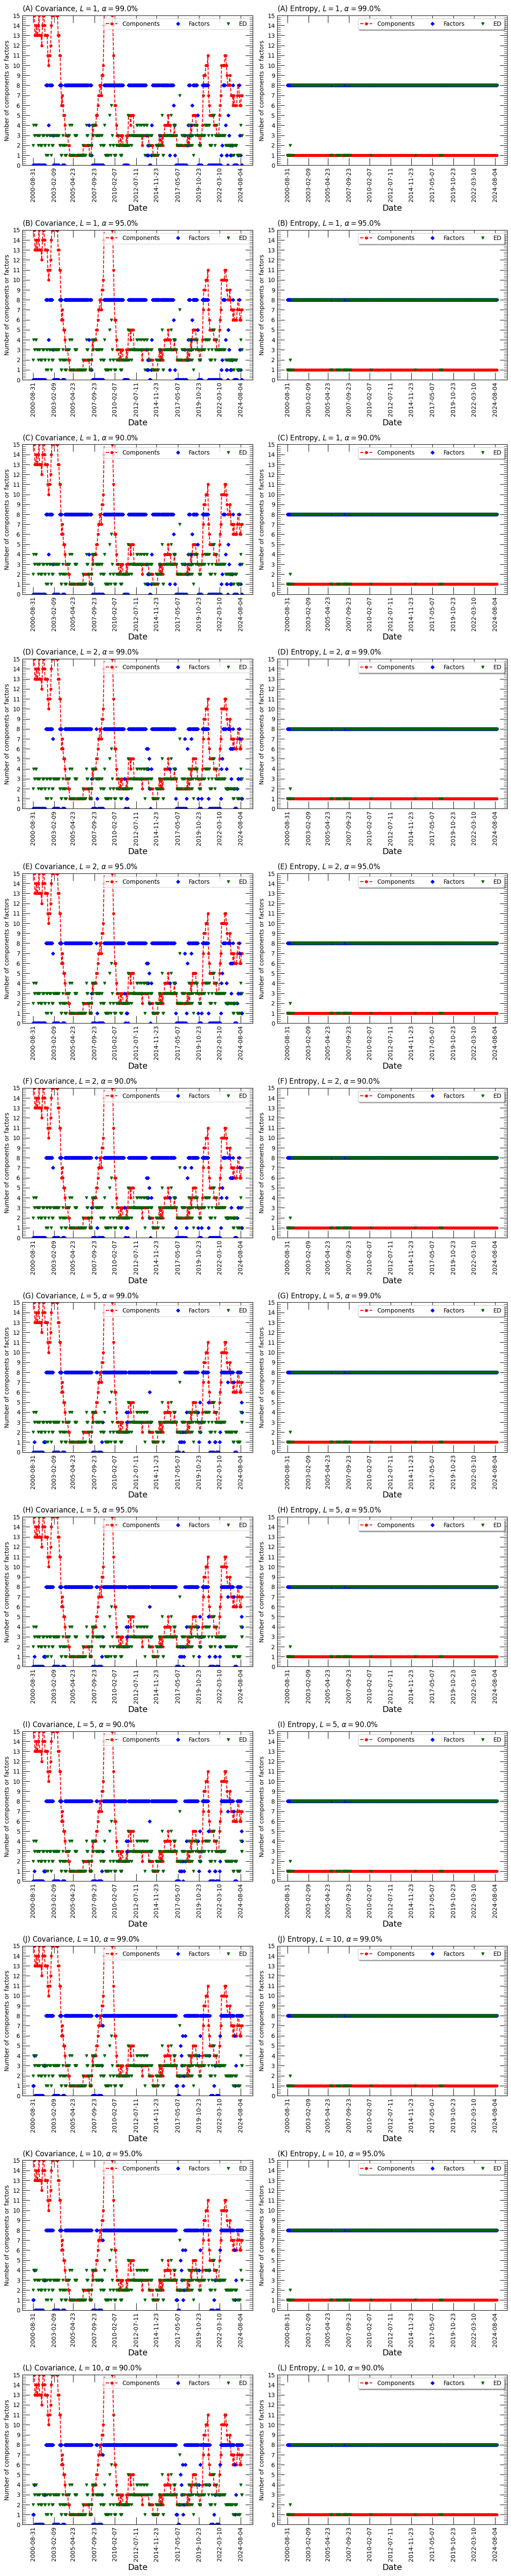

In [19]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as mtick # type: ignore

levels_ = df_final_3["level"].unique()
alphas_ = df_final_3["alpha"].unique()

fig,ax = plt.subplots(len(levels_) * len(alphas_), 2)
fig.set_size_inches(w = 12, h = 60)
ms = 4

for i in range(len(levels_)):
    for j in range(len(alphas_)):
        df_aux = df_final_3[((df_final_3["level"] == levels_[i]) & (df_final_3["alpha"] == alphas_[j]))]

        time_labels = pd.date_range(
            start = df_aux["final_date"].min(),
            end = df_aux["final_date"].max(),
            periods = 20
        ).strftime("%Y-%m-%d")

        # Components
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_components_cov"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_components_entropy"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        # Factors
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_factors_cov"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_factors_entropy"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        # Edge Distribution
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["edge_distribution_cov"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["edge_distribution_entropy"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        # Axis formatter
        ax[j + i * len(alphas_), 0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 0].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 0].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 0].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 0].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 0].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 0].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 0].legend(fancybox = True, shadow = False, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 0].set_title(
            r"({}) Covariance, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

        ax[j + i * len(alphas_), 1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 1].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 1].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 1].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 1].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 1].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 1].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 1].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 1].legend(fancybox = True, shadow = True, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 1].set_title(
            r"({}) Entropy, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_)+ 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

plt.tight_layout()
plt.show()

In [21]:
df_final_4 = []
for k in range(market_args_list.shape[0]):
    initial_date = market_args_list["initial_date"].values[k]
    final_date = market_args_list["final_date"].values[k]
    try:
        df_aux = emf.get_market_efficiency(
            df = df_stock_index,
            column_ = "z_score_zlr_no_market",
            min_bins = 10,
            precision = 12,
            log_path = log_path,
            log_filename = "log_market_efficiency_mxx_2",
            log_filename_entropy = "log_entropy_final_mxx_2",
            verbose = 1,
            tqdm_bar = True,
            market_args_list = (initial_date, final_date),
            bouchaud_filter = False,
            n = int(df_stock_index.shape[0] * 2),
            df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
            alphas = [0.01, 0.05, 0.10],
            k_max = 8,
            df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
            levels = [1, 2, 5, 10]
        )

        df_final_4.append(df_aux)

        print("Finished: {} - {}".format(initial_date, final_date))
    except:
        print("No done: {} - {}".format(initial_date, final_date))

df_final_4 = pd.concat(df_final_4)

100%|████████████████████| 378/378 [00:02<00:00, 153.93it/s]


Finished: 2000-01-04 - 2000-08-31


100%|████████████████████| 378/378 [00:02<00:00, 139.46it/s]


Finished: 2000-02-01 - 2000-09-28


100%|████████████████████| 378/378 [00:02<00:00, 156.58it/s]


Finished: 2000-02-29 - 2000-10-26


100%|████████████████████| 378/378 [00:02<00:00, 139.27it/s]


Finished: 2000-03-28 - 2000-11-23


100%|████████████████████| 406/406 [00:02<00:00, 154.59it/s]


Finished: 2000-04-27 - 2000-12-23


100%|████████████████████| 406/406 [00:02<00:00, 172.72it/s]


Finished: 2000-05-26 - 2001-01-21


100%|████████████████████| 406/406 [00:03<00:00, 134.66it/s]


Finished: 2000-06-23 - 2001-02-18


100%|█████████████████████| 406/406 [00:06<00:00, 62.29it/s]


Finished: 2000-07-21 - 2001-03-18


100%|█████████████████████| 435/435 [00:04<00:00, 89.99it/s]


Finished: 2000-08-18 - 2001-04-15


100%|█████████████████████| 465/465 [00:04<00:00, 96.64it/s]


Finished: 2000-09-15 - 2001-05-13


100%|█████████████████████| 465/465 [00:04<00:00, 97.95it/s]


Finished: 2000-10-16 - 2001-06-13


100%|█████████████████████| 496/496 [00:05<00:00, 98.06it/s]


Finished: 2000-11-13 - 2001-07-11


100%|█████████████████████| 496/496 [00:05<00:00, 95.65it/s]


Finished: 2000-12-11 - 2001-08-08


100%|████████████████████| 496/496 [00:04<00:00, 101.78it/s]


Finished: 2001-01-11 - 2001-09-08


100%|████████████████████| 496/496 [00:04<00:00, 102.86it/s]


Finished: 2001-02-08 - 2001-10-06


100%|█████████████████████| 496/496 [00:05<00:00, 98.29it/s]


Finished: 2001-03-08 - 2001-11-03


100%|████████████████████| 496/496 [00:04<00:00, 103.23it/s]


Finished: 2001-04-05 - 2001-12-01


100%|████████████████████| 496/496 [00:04<00:00, 102.05it/s]


Finished: 2001-05-08 - 2002-01-03


100%|████████████████████| 496/496 [00:04<00:00, 102.59it/s]


Finished: 2001-06-05 - 2002-01-31


100%|████████████████████| 496/496 [00:04<00:00, 104.05it/s]


Finished: 2001-07-03 - 2002-02-28


100%|████████████████████| 496/496 [00:04<00:00, 108.30it/s]


Finished: 2001-07-31 - 2002-03-28


100%|████████████████████| 496/496 [00:04<00:00, 103.59it/s]


Finished: 2001-08-28 - 2002-04-25


100%|████████████████████| 496/496 [00:04<00:00, 101.91it/s]


Finished: 2001-09-25 - 2002-05-23


100%|████████████████████| 496/496 [00:04<00:00, 102.07it/s]


Finished: 2001-10-23 - 2002-06-20


100%|████████████████████| 496/496 [00:04<00:00, 105.75it/s]


Finished: 2001-11-20 - 2002-07-18


100%|█████████████████████| 496/496 [00:05<00:00, 97.56it/s]


Finished: 2001-12-18 - 2002-08-15


100%|████████████████████| 496/496 [00:04<00:00, 105.40it/s]


Finished: 2002-01-22 - 2002-09-19


100%|████████████████████| 496/496 [00:04<00:00, 100.45it/s]


Finished: 2002-02-19 - 2002-10-17


100%|████████████████████| 496/496 [00:04<00:00, 105.40it/s]


Finished: 2002-03-19 - 2002-11-14


100%|████████████████████| 496/496 [00:04<00:00, 101.73it/s]


Finished: 2002-04-18 - 2002-12-14


100%|████████████████████| 496/496 [00:04<00:00, 105.67it/s]


Finished: 2002-05-17 - 2003-01-12


100%|████████████████████| 496/496 [00:04<00:00, 103.85it/s]


Finished: 2002-06-14 - 2003-02-09


100%|████████████████████| 496/496 [00:04<00:00, 105.07it/s]


Finished: 2002-07-12 - 2003-03-09


100%|█████████████████████| 496/496 [00:04<00:00, 99.73it/s]


Finished: 2002-08-09 - 2003-04-06


100%|█████████████████████| 465/465 [00:04<00:00, 99.23it/s]


Finished: 2002-09-06 - 2003-05-04


100%|█████████████████████| 465/465 [00:04<00:00, 99.44it/s]


Finished: 2002-10-04 - 2003-06-01


100%|████████████████████| 465/465 [00:04<00:00, 101.01it/s]


Finished: 2002-11-01 - 2003-06-29


100%|█████████████████████| 465/465 [00:04<00:00, 99.39it/s]


Finished: 2002-11-29 - 2003-07-27


100%|████████████████████| 465/465 [00:04<00:00, 100.33it/s]


Finished: 2003-01-02 - 2003-08-30


100%|████████████████████| 465/465 [00:04<00:00, 100.12it/s]


Finished: 2003-01-30 - 2003-09-27


100%|█████████████████████| 465/465 [00:04<00:00, 99.05it/s]


Finished: 2003-02-27 - 2003-10-25


100%|█████████████████████| 465/465 [00:04<00:00, 96.91it/s]


Finished: 2003-03-27 - 2003-11-22


100%|█████████████████████| 465/465 [00:04<00:00, 98.50it/s]


Finished: 2003-04-28 - 2003-12-24


100%|████████████████████| 496/496 [00:04<00:00, 101.50it/s]


Finished: 2003-05-27 - 2004-01-22


100%|█████████████████████| 496/496 [00:05<00:00, 99.03it/s]


Finished: 2003-06-24 - 2004-02-19


100%|████████████████████| 496/496 [00:04<00:00, 103.82it/s]


Finished: 2003-07-22 - 2004-03-18


100%|████████████████████| 496/496 [00:04<00:00, 102.25it/s]


Finished: 2003-08-19 - 2004-04-15


100%|████████████████████| 496/496 [00:04<00:00, 100.95it/s]


Finished: 2003-09-16 - 2004-05-13


100%|█████████████████████| 496/496 [00:05<00:00, 89.84it/s]


Finished: 2003-10-14 - 2004-06-10


100%|█████████████████████| 496/496 [00:05<00:00, 94.66it/s]


Finished: 2003-11-11 - 2004-07-08


100%|█████████████████████| 496/496 [00:05<00:00, 91.31it/s]


Finished: 2003-12-09 - 2004-08-05


100%|█████████████████████| 496/496 [00:05<00:00, 93.59it/s]


Finished: 2004-01-13 - 2004-09-09


100%|█████████████████████| 496/496 [00:05<00:00, 92.47it/s]


Finished: 2004-02-10 - 2004-10-07


100%|█████████████████████| 496/496 [00:05<00:00, 94.09it/s]


Finished: 2004-03-09 - 2004-11-04


100%|█████████████████████| 496/496 [00:05<00:00, 90.21it/s]


Finished: 2004-04-06 - 2004-12-02


100%|█████████████████████| 496/496 [00:05<00:00, 91.76it/s]


Finished: 2004-05-06 - 2005-01-01


100%|█████████████████████| 496/496 [00:05<00:00, 97.85it/s]


Finished: 2004-06-03 - 2005-01-29


100%|█████████████████████| 496/496 [00:05<00:00, 94.32it/s]


Finished: 2004-07-01 - 2005-02-26


100%|█████████████████████| 496/496 [00:05<00:00, 90.83it/s]


Finished: 2004-07-29 - 2005-03-26


100%|█████████████████████| 496/496 [00:05<00:00, 82.80it/s]


Finished: 2004-08-26 - 2005-04-23


100%|█████████████████████| 496/496 [00:05<00:00, 97.70it/s]


Finished: 2004-09-23 - 2005-05-21


100%|█████████████████████| 496/496 [00:04<00:00, 99.80it/s]


Finished: 2004-10-21 - 2005-06-18


100%|████████████████████| 496/496 [00:04<00:00, 100.06it/s]


Finished: 2004-11-18 - 2005-07-16


100%|█████████████████████| 496/496 [00:05<00:00, 92.09it/s]


Finished: 2004-12-16 - 2005-08-13


100%|█████████████████████| 496/496 [00:05<00:00, 96.70it/s]


Finished: 2005-01-17 - 2005-09-14


100%|████████████████████| 496/496 [00:04<00:00, 107.34it/s]


Finished: 2005-02-14 - 2005-10-12


100%|█████████████████████| 528/528 [00:05<00:00, 98.45it/s]


Finished: 2005-03-14 - 2005-11-09


100%|████████████████████| 528/528 [00:04<00:00, 111.51it/s]


Finished: 2005-04-13 - 2005-12-09


100%|████████████████████| 528/528 [00:04<00:00, 109.12it/s]


Finished: 2005-05-11 - 2006-01-06


100%|████████████████████| 528/528 [00:04<00:00, 110.03it/s]


Finished: 2005-06-08 - 2006-02-03


100%|█████████████████████| 528/528 [00:05<00:00, 95.52it/s]


Finished: 2005-07-06 - 2006-03-03


100%|████████████████████| 528/528 [00:05<00:00, 100.03it/s]


Finished: 2005-08-03 - 2006-03-31


100%|████████████████████| 528/528 [00:04<00:00, 106.05it/s]


Finished: 2005-08-31 - 2006-04-28


100%|████████████████████| 528/528 [00:05<00:00, 104.44it/s]


Finished: 2005-09-28 - 2006-05-26


100%|████████████████████| 528/528 [00:04<00:00, 105.76it/s]


Finished: 2005-10-26 - 2006-06-23


100%|████████████████████| 528/528 [00:04<00:00, 110.18it/s]


Finished: 2005-11-23 - 2006-07-21


100%|████████████████████| 528/528 [00:05<00:00, 104.21it/s]


Finished: 2005-12-21 - 2006-08-18


100%|████████████████████| 528/528 [00:04<00:00, 110.00it/s]


Finished: 2006-01-19 - 2006-09-16


100%|████████████████████| 528/528 [00:04<00:00, 105.92it/s]


Finished: 2006-02-16 - 2006-10-14


100%|████████████████████| 528/528 [00:04<00:00, 114.62it/s]


Finished: 2006-03-16 - 2006-11-11


100%|████████████████████| 528/528 [00:04<00:00, 115.01it/s]


Finished: 2006-04-13 - 2006-12-09


100%|████████████████████| 528/528 [00:04<00:00, 112.14it/s]


Finished: 2006-05-16 - 2007-01-11


100%|████████████████████| 528/528 [00:05<00:00, 103.26it/s]


Finished: 2006-06-13 - 2007-02-08


100%|████████████████████| 528/528 [00:05<00:00, 100.59it/s]


Finished: 2006-07-11 - 2007-03-08


100%|████████████████████| 528/528 [00:04<00:00, 108.16it/s]


Finished: 2006-08-08 - 2007-04-05


100%|████████████████████| 528/528 [00:04<00:00, 109.12it/s]


Finished: 2006-09-05 - 2007-05-03


100%|████████████████████| 561/561 [00:05<00:00, 109.32it/s]


Finished: 2006-10-03 - 2007-05-31


100%|████████████████████| 595/595 [00:05<00:00, 113.85it/s]


Finished: 2006-10-31 - 2007-06-28


100%|████████████████████| 595/595 [00:05<00:00, 114.07it/s]


Finished: 2006-11-28 - 2007-07-26


100%|████████████████████| 595/595 [00:05<00:00, 116.14it/s]


Finished: 2006-12-28 - 2007-08-25


100%|████████████████████| 595/595 [00:05<00:00, 112.59it/s]


Finished: 2007-01-26 - 2007-09-23


100%|████████████████████| 595/595 [00:05<00:00, 114.16it/s]


Finished: 2007-02-23 - 2007-10-21


100%|████████████████████| 595/595 [00:05<00:00, 115.09it/s]


Finished: 2007-03-23 - 2007-11-18


100%|████████████████████| 595/595 [00:05<00:00, 115.22it/s]


Finished: 2007-04-24 - 2007-12-20


100%|████████████████████| 595/595 [00:05<00:00, 111.07it/s]


Finished: 2007-05-23 - 2008-01-18


100%|████████████████████| 595/595 [00:05<00:00, 110.43it/s]


Finished: 2007-06-21 - 2008-02-16


100%|████████████████████| 595/595 [00:05<00:00, 111.05it/s]


Finished: 2007-07-19 - 2008-03-15


100%|████████████████████| 595/595 [00:05<00:00, 113.12it/s]


Finished: 2007-08-16 - 2008-04-12


100%|████████████████████| 595/595 [00:05<00:00, 113.77it/s]


Finished: 2007-09-13 - 2008-05-10


100%|████████████████████| 595/595 [00:05<00:00, 112.96it/s]


Finished: 2007-10-11 - 2008-06-07


100%|████████████████████| 595/595 [00:05<00:00, 111.36it/s]


Finished: 2007-11-08 - 2008-07-05


100%|████████████████████| 595/595 [00:05<00:00, 115.02it/s]


Finished: 2007-12-06 - 2008-08-02


100%|████████████████████| 595/595 [00:05<00:00, 113.75it/s]


Finished: 2008-01-10 - 2008-09-06


100%|████████████████████| 595/595 [00:05<00:00, 115.83it/s]


Finished: 2008-02-07 - 2008-10-04


100%|████████████████████| 561/561 [00:05<00:00, 111.89it/s]


Finished: 2008-03-06 - 2008-11-01


100%|████████████████████| 561/561 [00:04<00:00, 113.04it/s]


Finished: 2008-04-07 - 2008-12-03


100%|████████████████████| 561/561 [00:05<00:00, 106.52it/s]


Finished: 2008-05-06 - 2009-01-01


100%|████████████████████| 561/561 [00:05<00:00, 109.21it/s]


Finished: 2008-06-03 - 2009-01-29


100%|████████████████████| 561/561 [00:05<00:00, 111.98it/s]


Finished: 2008-07-01 - 2009-02-26


100%|████████████████████| 561/561 [00:05<00:00, 108.90it/s]


Finished: 2008-07-29 - 2009-03-26


100%|████████████████████| 561/561 [00:04<00:00, 114.62it/s]


Finished: 2008-08-26 - 2009-04-23


100%|████████████████████| 561/561 [00:04<00:00, 112.59it/s]


Finished: 2008-09-23 - 2009-05-21


100%|████████████████████| 561/561 [00:05<00:00, 107.55it/s]


Finished: 2008-10-21 - 2009-06-18


100%|████████████████████| 595/595 [00:05<00:00, 113.16it/s]


Finished: 2008-11-18 - 2009-07-16


100%|████████████████████| 595/595 [00:05<00:00, 114.17it/s]


Finished: 2008-12-16 - 2009-08-13


100%|████████████████████| 595/595 [00:05<00:00, 115.52it/s]


Finished: 2009-01-20 - 2009-09-17


100%|████████████████████| 595/595 [00:05<00:00, 113.85it/s]


Finished: 2009-02-17 - 2009-10-15


100%|████████████████████| 595/595 [00:05<00:00, 112.15it/s]


Finished: 2009-03-17 - 2009-11-12


100%|████████████████████| 595/595 [00:05<00:00, 112.30it/s]


Finished: 2009-04-16 - 2009-12-12


100%|████████████████████| 595/595 [00:05<00:00, 112.21it/s]


Finished: 2009-05-15 - 2010-01-10


100%|████████████████████| 595/595 [00:05<00:00, 117.91it/s]


Finished: 2009-06-12 - 2010-02-07


100%|████████████████████| 595/595 [00:05<00:00, 113.90it/s]


Finished: 2009-07-10 - 2010-03-07


100%|████████████████████| 595/595 [00:05<00:00, 117.45it/s]


Finished: 2009-08-07 - 2010-04-04


100%|████████████████████| 595/595 [00:05<00:00, 110.92it/s]


Finished: 2009-09-04 - 2010-05-02


100%|████████████████████| 595/595 [00:05<00:00, 112.14it/s]


Finished: 2009-10-02 - 2010-05-30


100%|████████████████████| 595/595 [00:05<00:00, 115.53it/s]


Finished: 2009-10-30 - 2010-06-27


100%|████████████████████| 595/595 [00:05<00:00, 115.21it/s]


Finished: 2009-11-27 - 2010-07-25


100%|████████████████████| 595/595 [00:05<00:00, 113.89it/s]


Finished: 2009-12-29 - 2010-08-26


100%|████████████████████| 630/630 [00:05<00:00, 118.07it/s]


Finished: 2010-01-28 - 2010-09-25


100%|████████████████████| 630/630 [00:05<00:00, 115.26it/s]


Finished: 2010-02-25 - 2010-10-23


100%|████████████████████| 630/630 [00:05<00:00, 116.79it/s]


Finished: 2010-03-25 - 2010-11-20


100%|████████████████████| 630/630 [00:05<00:00, 117.93it/s]


Finished: 2010-04-26 - 2010-12-22


100%|████████████████████| 630/630 [00:05<00:00, 117.58it/s]


Finished: 2010-05-24 - 2011-01-19


100%|████████████████████| 630/630 [00:05<00:00, 117.87it/s]


Finished: 2010-06-21 - 2011-02-16


100%|████████████████████| 630/630 [00:05<00:00, 113.36it/s]


Finished: 2010-07-19 - 2011-03-16


100%|████████████████████| 630/630 [00:05<00:00, 114.61it/s]


Finished: 2010-08-16 - 2011-04-13


100%|████████████████████| 630/630 [00:05<00:00, 113.67it/s]


Finished: 2010-09-13 - 2011-05-11


100%|████████████████████| 630/630 [00:05<00:00, 118.28it/s]


Finished: 2010-10-11 - 2011-06-08


100%|████████████████████| 630/630 [00:05<00:00, 115.27it/s]


Finished: 2010-11-08 - 2011-07-06


100%|████████████████████| 630/630 [00:05<00:00, 112.98it/s]


Finished: 2010-12-06 - 2011-08-03


100%|████████████████████| 630/630 [00:05<00:00, 118.08it/s]


Finished: 2011-01-05 - 2011-09-02


100%|████████████████████| 630/630 [00:05<00:00, 116.61it/s]


Finished: 2011-02-02 - 2011-09-30


100%|████████████████████| 630/630 [00:05<00:00, 115.18it/s]


Finished: 2011-03-02 - 2011-10-28


100%|████████████████████| 630/630 [00:05<00:00, 119.25it/s]


Finished: 2011-03-30 - 2011-11-25


100%|████████████████████| 630/630 [00:05<00:00, 112.48it/s]


Finished: 2011-04-29 - 2011-12-25


100%|████████████████████| 630/630 [00:05<00:00, 113.05it/s]


Finished: 2011-05-27 - 2012-01-22


100%|████████████████████| 630/630 [00:05<00:00, 118.28it/s]


Finished: 2011-06-24 - 2012-02-19


100%|████████████████████| 630/630 [00:05<00:00, 118.09it/s]


Finished: 2011-07-22 - 2012-03-18


100%|████████████████████| 630/630 [00:05<00:00, 115.35it/s]


Finished: 2011-08-19 - 2012-04-15


100%|████████████████████| 630/630 [00:05<00:00, 118.68it/s]


Finished: 2011-09-16 - 2012-05-13


100%|████████████████████| 630/630 [00:05<00:00, 116.87it/s]


Finished: 2011-10-17 - 2012-06-13


100%|████████████████████| 630/630 [00:05<00:00, 115.44it/s]


Finished: 2011-11-14 - 2012-07-11


100%|████████████████████| 630/630 [00:05<00:00, 118.49it/s]


Finished: 2011-12-12 - 2012-08-08


100%|████████████████████| 630/630 [00:05<00:00, 118.68it/s]


Finished: 2012-01-10 - 2012-09-06


100%|████████████████████| 630/630 [00:05<00:00, 113.38it/s]


Finished: 2012-02-07 - 2012-10-04


100%|████████████████████| 630/630 [00:05<00:00, 113.67it/s]


Finished: 2012-03-06 - 2012-11-01


100%|████████████████████| 630/630 [00:05<00:00, 116.81it/s]


Finished: 2012-04-03 - 2012-11-29


100%|████████████████████| 630/630 [00:05<00:00, 115.99it/s]


Finished: 2012-05-04 - 2012-12-30


100%|████████████████████| 630/630 [00:05<00:00, 118.21it/s]


Finished: 2012-06-01 - 2013-01-27


100%|████████████████████| 630/630 [00:05<00:00, 119.29it/s]


Finished: 2012-06-29 - 2013-02-24


100%|████████████████████| 630/630 [00:05<00:00, 110.16it/s]


Finished: 2012-07-27 - 2013-03-24


100%|████████████████████| 630/630 [00:05<00:00, 119.78it/s]


Finished: 2012-08-24 - 2013-04-21


100%|████████████████████| 630/630 [00:05<00:00, 120.53it/s]


Finished: 2012-09-21 - 2013-05-19


100%|████████████████████| 630/630 [00:05<00:00, 116.56it/s]


Finished: 2012-10-22 - 2013-06-19


100%|████████████████████| 630/630 [00:05<00:00, 119.87it/s]


Finished: 2012-11-19 - 2013-07-17


100%|████████████████████| 630/630 [00:05<00:00, 119.02it/s]


Finished: 2012-12-17 - 2013-08-14


100%|████████████████████| 630/630 [00:05<00:00, 113.17it/s]


Finished: 2013-01-21 - 2013-09-18


100%|████████████████████| 630/630 [00:05<00:00, 118.96it/s]


Finished: 2013-02-18 - 2013-10-16


100%|████████████████████| 630/630 [00:05<00:00, 117.85it/s]


Finished: 2013-03-18 - 2013-11-13


100%|████████████████████| 666/666 [00:05<00:00, 117.14it/s]


Finished: 2013-04-17 - 2013-12-13


100%|████████████████████| 666/666 [00:05<00:00, 120.69it/s]


Finished: 2013-05-16 - 2014-01-11


100%|████████████████████| 666/666 [00:05<00:00, 119.44it/s]


Finished: 2013-06-13 - 2014-02-08


100%|████████████████████| 666/666 [00:05<00:00, 119.36it/s]


Finished: 2013-07-11 - 2014-03-08


100%|████████████████████| 666/666 [00:05<00:00, 119.53it/s]


Finished: 2013-08-08 - 2014-04-05


100%|████████████████████| 666/666 [00:05<00:00, 124.10it/s]


Finished: 2013-09-05 - 2014-05-03


100%|████████████████████| 666/666 [00:05<00:00, 116.76it/s]


Finished: 2013-10-04 - 2014-06-01


100%|████████████████████| 666/666 [00:05<00:00, 120.34it/s]


Finished: 2013-11-01 - 2014-06-29


100%|████████████████████| 666/666 [00:05<00:00, 121.22it/s]


Finished: 2013-11-29 - 2014-07-27


100%|████████████████████| 666/666 [00:05<00:00, 119.33it/s]


Finished: 2014-01-03 - 2014-08-31


100%|████████████████████| 666/666 [00:05<00:00, 120.13it/s]


Finished: 2014-01-31 - 2014-09-28


100%|████████████████████| 666/666 [00:05<00:00, 118.69it/s]


Finished: 2014-02-28 - 2014-10-26


100%|████████████████████| 666/666 [00:05<00:00, 120.73it/s]


Finished: 2014-03-28 - 2014-11-23


100%|████████████████████| 666/666 [00:05<00:00, 118.45it/s]


Finished: 2014-04-29 - 2014-12-25


100%|████████████████████| 666/666 [00:06<00:00, 107.25it/s]


Finished: 2014-05-28 - 2015-01-23


100%|████████████████████| 666/666 [00:05<00:00, 117.99it/s]


Finished: 2014-06-25 - 2015-02-20


100%|████████████████████| 703/703 [00:05<00:00, 122.08it/s]


Finished: 2014-07-23 - 2015-03-20


100%|████████████████████| 703/703 [00:05<00:00, 122.42it/s]


Finished: 2014-08-20 - 2015-04-17


100%|████████████████████| 703/703 [00:05<00:00, 120.85it/s]


Finished: 2014-09-17 - 2015-05-15


100%|████████████████████| 703/703 [00:05<00:00, 123.67it/s]


Finished: 2014-10-16 - 2015-06-13


100%|████████████████████| 703/703 [00:05<00:00, 122.49it/s]


Finished: 2014-11-13 - 2015-07-11


100%|████████████████████| 703/703 [00:05<00:00, 119.18it/s]


Finished: 2014-12-11 - 2015-08-08


100%|████████████████████| 703/703 [00:05<00:00, 122.69it/s]


Finished: 2015-01-15 - 2015-09-12


100%|████████████████████| 703/703 [00:05<00:00, 118.87it/s]


Finished: 2015-02-12 - 2015-10-10


100%|████████████████████| 703/703 [00:05<00:00, 119.95it/s]


Finished: 2015-03-12 - 2015-11-07


100%|████████████████████| 703/703 [00:05<00:00, 119.16it/s]


Finished: 2015-04-13 - 2015-12-09


100%|████████████████████| 703/703 [00:05<00:00, 118.14it/s]


Finished: 2015-05-12 - 2016-01-07


100%|████████████████████| 703/703 [00:05<00:00, 122.19it/s]


Finished: 2015-06-10 - 2016-02-05


100%|████████████████████| 741/741 [00:06<00:00, 120.10it/s]


Finished: 2015-07-08 - 2016-03-04


100%|████████████████████| 741/741 [00:06<00:00, 123.16it/s]


Finished: 2015-08-05 - 2016-04-01


100%|████████████████████| 741/741 [00:05<00:00, 125.19it/s]


Finished: 2015-09-02 - 2016-04-29


100%|████████████████████| 741/741 [00:06<00:00, 121.21it/s]


Finished: 2015-09-30 - 2016-05-27


100%|████████████████████| 741/741 [00:05<00:00, 123.53it/s]


Finished: 2015-10-28 - 2016-06-24


100%|████████████████████| 741/741 [00:06<00:00, 123.31it/s]


Finished: 2015-11-25 - 2016-07-22


100%|████████████████████| 741/741 [00:06<00:00, 122.29it/s]


Finished: 2015-12-23 - 2016-08-19


100%|████████████████████| 741/741 [00:06<00:00, 118.44it/s]


Finished: 2016-01-26 - 2016-09-22


100%|████████████████████| 741/741 [00:05<00:00, 124.12it/s]


Finished: 2016-02-23 - 2016-10-20


100%|████████████████████| 741/741 [00:06<00:00, 122.76it/s]


Finished: 2016-03-22 - 2016-11-17


100%|████████████████████| 741/741 [00:05<00:00, 124.26it/s]


Finished: 2016-04-21 - 2016-12-17


100%|████████████████████| 741/741 [00:06<00:00, 121.33it/s]


Finished: 2016-05-20 - 2017-01-15


100%|████████████████████| 741/741 [00:06<00:00, 121.67it/s]


Finished: 2016-06-17 - 2017-02-12


100%|████████████████████| 741/741 [00:06<00:00, 123.41it/s]


Finished: 2016-07-15 - 2017-03-12


100%|████████████████████| 741/741 [00:05<00:00, 123.96it/s]


Finished: 2016-08-12 - 2017-04-09


100%|████████████████████| 741/741 [00:05<00:00, 125.29it/s]


Finished: 2016-09-09 - 2017-05-07


100%|████████████████████| 741/741 [00:06<00:00, 117.87it/s]


Finished: 2016-10-10 - 2017-06-07


100%|████████████████████| 741/741 [00:05<00:00, 125.73it/s]


Finished: 2016-11-07 - 2017-07-05


100%|████████████████████| 741/741 [00:05<00:00, 124.81it/s]


Finished: 2016-12-05 - 2017-08-02


100%|████████████████████| 741/741 [00:06<00:00, 120.98it/s]


Finished: 2017-01-03 - 2017-08-31


100%|████████████████████| 741/741 [00:05<00:00, 124.60it/s]


Finished: 2017-01-31 - 2017-09-28


100%|████████████████████| 741/741 [00:06<00:00, 121.27it/s]


Finished: 2017-02-28 - 2017-10-26


100%|████████████████████| 741/741 [00:06<00:00, 121.09it/s]


Finished: 2017-03-28 - 2017-11-23


100%|████████████████████| 741/741 [00:05<00:00, 123.51it/s]


Finished: 2017-04-27 - 2017-12-23


100%|████████████████████| 741/741 [00:05<00:00, 125.37it/s]


Finished: 2017-05-26 - 2018-01-21


100%|████████████████████| 741/741 [00:06<00:00, 122.03it/s]


Finished: 2017-06-26 - 2018-02-21


100%|████████████████████| 741/741 [00:05<00:00, 124.83it/s]


Finished: 2017-07-24 - 2018-03-21


100%|████████████████████| 741/741 [00:05<00:00, 124.79it/s]


Finished: 2017-08-21 - 2018-04-18


100%|████████████████████| 741/741 [00:06<00:00, 122.70it/s]


Finished: 2017-09-18 - 2018-05-16


100%|████████████████████| 741/741 [00:06<00:00, 122.87it/s]


Finished: 2017-10-17 - 2018-06-14


100%|████████████████████| 741/741 [00:06<00:00, 122.38it/s]


Finished: 2017-11-15 - 2018-07-13


100%|████████████████████| 741/741 [00:05<00:00, 127.27it/s]


Finished: 2017-12-13 - 2018-08-10


100%|████████████████████| 780/780 [00:06<00:00, 115.86it/s]


Finished: 2018-01-15 - 2018-09-12


100%|████████████████████| 780/780 [00:06<00:00, 121.72it/s]


Finished: 2018-02-12 - 2018-10-10


100%|████████████████████| 780/780 [00:06<00:00, 122.38it/s]


Finished: 2018-03-12 - 2018-11-07


100%|████████████████████| 780/780 [00:06<00:00, 124.85it/s]


Finished: 2018-04-11 - 2018-12-07


100%|████████████████████| 780/780 [00:06<00:00, 124.72it/s]


Finished: 2018-05-10 - 2019-01-05


100%|████████████████████| 780/780 [00:06<00:00, 123.58it/s]


Finished: 2018-06-08 - 2019-02-03


100%|████████████████████| 780/780 [00:06<00:00, 120.76it/s]


Finished: 2018-07-06 - 2019-03-03


100%|████████████████████| 820/820 [00:06<00:00, 119.49it/s]


Finished: 2018-08-03 - 2019-03-31


100%|████████████████████| 820/820 [00:06<00:00, 119.44it/s]


Finished: 2018-08-31 - 2019-04-28


100%|████████████████████| 820/820 [00:06<00:00, 120.89it/s]


Finished: 2018-09-28 - 2019-05-26


100%|████████████████████| 820/820 [00:07<00:00, 105.29it/s]


Finished: 2018-10-29 - 2019-06-26


100%|█████████████████████| 820/820 [00:09<00:00, 82.41it/s]


Finished: 2018-11-26 - 2019-07-24


100%|█████████████████████| 820/820 [00:10<00:00, 76.26it/s]


Finished: 2018-12-27 - 2019-08-24


100%|█████████████████████| 820/820 [00:11<00:00, 73.56it/s]


Finished: 2019-01-28 - 2019-09-25


100%|█████████████████████| 820/820 [00:12<00:00, 67.03it/s]


Finished: 2019-02-25 - 2019-10-23


100%|█████████████████████| 820/820 [00:13<00:00, 62.67it/s]


Finished: 2019-03-25 - 2019-11-20


100%|█████████████████████| 820/820 [00:13<00:00, 62.68it/s]


Finished: 2019-04-24 - 2019-12-20


100%|█████████████████████| 820/820 [00:13<00:00, 59.19it/s]


Finished: 2019-05-23 - 2020-01-18


100%|█████████████████████| 820/820 [00:14<00:00, 57.85it/s]


Finished: 2019-06-21 - 2020-02-16


100%|█████████████████████| 820/820 [00:14<00:00, 57.96it/s]


Finished: 2019-07-19 - 2020-03-15


100%|█████████████████████| 820/820 [00:15<00:00, 54.47it/s]


Finished: 2019-08-16 - 2020-04-12


100%|█████████████████████| 820/820 [00:14<00:00, 57.60it/s]


Finished: 2019-09-13 - 2020-05-10


100%|█████████████████████| 820/820 [00:14<00:00, 55.05it/s]


Finished: 2019-10-14 - 2020-06-10


100%|█████████████████████| 820/820 [00:15<00:00, 52.74it/s]


Finished: 2019-11-11 - 2020-07-08


100%|█████████████████████| 820/820 [00:15<00:00, 52.26it/s]


Finished: 2019-12-09 - 2020-08-05


100%|█████████████████████| 820/820 [00:15<00:00, 52.69it/s]


Finished: 2020-01-13 - 2020-09-09


100%|█████████████████████| 820/820 [00:15<00:00, 52.64it/s]


Finished: 2020-02-10 - 2020-10-07


100%|█████████████████████| 820/820 [00:17<00:00, 47.59it/s]


Finished: 2020-03-09 - 2020-11-04


100%|█████████████████████| 820/820 [00:16<00:00, 48.36it/s]


Finished: 2020-04-06 - 2020-12-02


100%|█████████████████████| 820/820 [00:18<00:00, 43.28it/s]


Finished: 2020-05-07 - 2021-01-02


100%|█████████████████████| 820/820 [00:18<00:00, 45.54it/s]


Finished: 2020-06-05 - 2021-01-31


100%|█████████████████████| 861/861 [00:18<00:00, 46.44it/s]


Finished: 2020-07-03 - 2021-02-28


100%|█████████████████████| 861/861 [00:20<00:00, 42.24it/s]


Finished: 2020-07-31 - 2021-03-28


100%|█████████████████████| 861/861 [00:20<00:00, 42.98it/s]


Finished: 2020-08-28 - 2021-04-25


100%|█████████████████████| 861/861 [00:20<00:00, 42.13it/s]


Finished: 2020-09-25 - 2021-05-23


100%|█████████████████████| 861/861 [00:20<00:00, 41.95it/s]


Finished: 2020-10-23 - 2021-06-20


100%|█████████████████████| 861/861 [00:21<00:00, 40.27it/s]


Finished: 2020-11-20 - 2021-07-18


100%|█████████████████████| 861/861 [00:22<00:00, 38.67it/s]


Finished: 2020-12-18 - 2021-08-15


100%|█████████████████████| 861/861 [00:23<00:00, 36.21it/s]


Finished: 2021-01-21 - 2021-09-18


100%|█████████████████████| 861/861 [00:22<00:00, 38.41it/s]


Finished: 2021-02-18 - 2021-10-16


100%|█████████████████████| 861/861 [00:24<00:00, 35.03it/s]


Finished: 2021-03-18 - 2021-11-13


100%|█████████████████████| 861/861 [00:23<00:00, 36.37it/s]


Finished: 2021-04-19 - 2021-12-15


100%|█████████████████████| 861/861 [00:25<00:00, 33.18it/s]


Finished: 2021-05-17 - 2022-01-12


100%|█████████████████████| 861/861 [00:25<00:00, 34.31it/s]


Finished: 2021-06-15 - 2022-02-10


100%|█████████████████████| 861/861 [00:25<00:00, 33.67it/s]


Finished: 2021-07-13 - 2022-03-10


100%|█████████████████████| 861/861 [00:26<00:00, 31.98it/s]


Finished: 2021-08-10 - 2022-04-07


100%|█████████████████████| 861/861 [00:28<00:00, 30.58it/s]


Finished: 2021-09-07 - 2022-05-05


100%|█████████████████████| 903/903 [00:26<00:00, 34.35it/s]


Finished: 2021-10-05 - 2022-06-02


100%|█████████████████████| 903/903 [00:25<00:00, 35.43it/s]


Finished: 2021-11-02 - 2022-06-30


100%|█████████████████████| 903/903 [00:27<00:00, 32.81it/s]


Finished: 2021-11-30 - 2022-07-28


100%|█████████████████████| 903/903 [00:31<00:00, 28.62it/s]


Finished: 2021-12-29 - 2022-08-26


100%|███████████████████| 903/903 [8:43:22<00:00, 34.78s/it]


Finished: 2022-01-27 - 2022-09-24


100%|█████████████████████| 903/903 [00:14<00:00, 62.24it/s]


Finished: 2022-02-24 - 2022-10-22


100%|█████████████████████| 903/903 [00:10<00:00, 84.99it/s]


Finished: 2022-03-24 - 2022-11-19


100%|█████████████████████| 903/903 [00:12<00:00, 74.64it/s]


Finished: 2022-04-25 - 2022-12-21


100%|█████████████████████| 903/903 [00:10<00:00, 83.04it/s]


Finished: 2022-05-23 - 2023-01-18


100%|█████████████████████| 903/903 [00:10<00:00, 90.08it/s]


Finished: 2022-06-20 - 2023-02-15


100%|█████████████████████| 946/946 [00:15<00:00, 59.37it/s]


Finished: 2022-07-18 - 2023-03-15


100%|████████████████████| 946/946 [00:05<00:00, 167.85it/s]


Finished: 2022-08-15 - 2023-04-12


100%|████████████████████| 946/946 [00:05<00:00, 170.82it/s]


Finished: 2022-09-12 - 2023-05-10


100%|████████████████████| 946/946 [00:05<00:00, 178.56it/s]


Finished: 2022-10-10 - 2023-06-07


100%|████████████████████| 946/946 [00:05<00:00, 161.74it/s]


Finished: 2022-11-07 - 2023-07-05


100%|████████████████████| 946/946 [00:05<00:00, 177.57it/s]


Finished: 2022-12-05 - 2023-08-02


100%|████████████████████| 946/946 [00:05<00:00, 178.43it/s]


Finished: 2023-01-03 - 2023-08-31


100%|████████████████████| 946/946 [00:05<00:00, 177.06it/s]


Finished: 2023-01-31 - 2023-09-28


100%|████████████████████| 946/946 [00:07<00:00, 132.98it/s]


Finished: 2023-02-28 - 2023-10-26


100%|████████████████████| 946/946 [00:05<00:00, 176.93it/s]


Finished: 2023-03-28 - 2023-11-23


100%|████████████████████| 946/946 [00:05<00:00, 176.67it/s]


Finished: 2023-04-27 - 2023-12-23


100%|████████████████████| 946/946 [00:05<00:00, 177.76it/s]


Finished: 2023-05-26 - 2024-01-21


100%|████████████████████| 946/946 [00:05<00:00, 175.78it/s]


Finished: 2023-06-23 - 2024-02-18


100%|████████████████████| 946/946 [00:05<00:00, 179.62it/s]


Finished: 2023-07-21 - 2024-03-17


100%|████████████████████| 946/946 [00:05<00:00, 176.75it/s]


Finished: 2023-08-18 - 2024-04-14


100%|████████████████████| 946/946 [00:06<00:00, 150.37it/s]


Finished: 2023-09-15 - 2024-05-12


100%|████████████████████| 946/946 [00:05<00:00, 179.73it/s]


Finished: 2023-10-13 - 2024-06-09


100%|████████████████████| 946/946 [00:05<00:00, 173.38it/s]


Finished: 2023-11-10 - 2024-07-07


100%|████████████████████| 946/946 [00:04<00:00, 193.07it/s]


Finished: 2023-12-08 - 2024-08-04


100%|████████████████████| 946/946 [00:05<00:00, 183.01it/s]


Finished: 2024-01-10 - 2024-09-06


100%|████████████████████| 946/946 [00:04<00:00, 228.06it/s]


Finished: 2024-02-07 - 2024-10-04


0it [00:00, ?it/s]


No done: 2024-03-06 - 2024-11-01


0it [00:00, ?it/s]


No done: 2024-04-05 - 2024-12-01


0it [00:00, ?it/s]


No done: 2024-05-06 - 2025-01-01


0it [00:00, ?it/s]


No done: 2024-06-03 - 2025-01-29


0it [00:00, ?it/s]

No done: 2024-07-01 - 2025-02-26


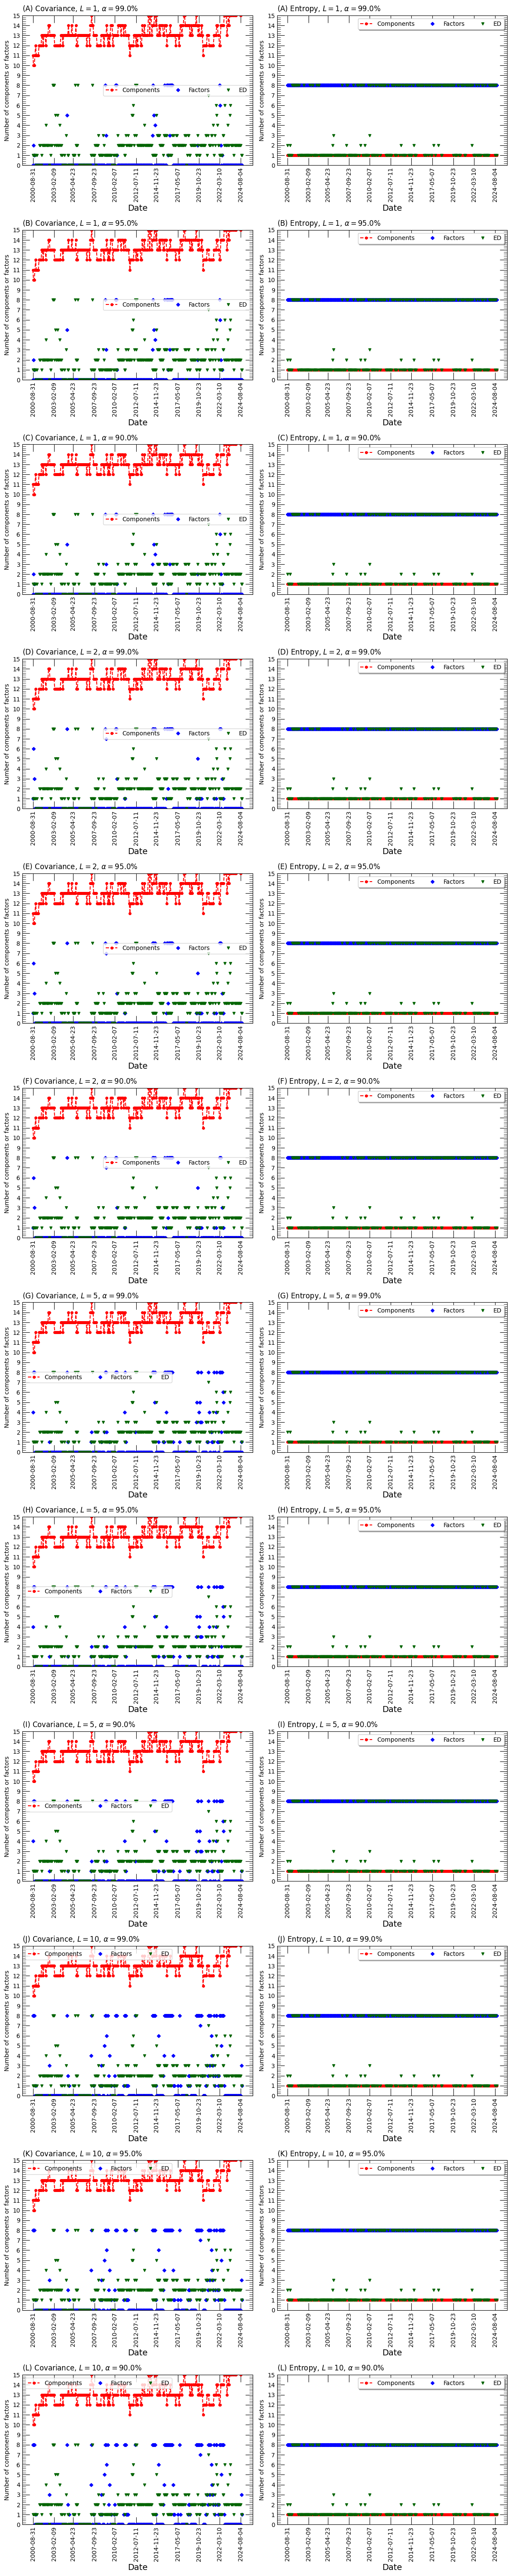

In [22]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as mtick # type: ignore

levels_ = df_final_4["level"].unique()
alphas_ = df_final_4["alpha"].unique()

fig,ax = plt.subplots(len(levels_) * len(alphas_), 2)
fig.set_size_inches(w = 12, h = 60)
ms = 4

for i in range(len(levels_)):
    for j in range(len(alphas_)):
        df_aux = df_final_4[((df_final_4["level"] == levels_[i]) & (df_final_4["alpha"] == alphas_[j]))]

        time_labels = pd.date_range(
            start = df_aux["final_date"].min(),
            end = df_aux["final_date"].max(),
            periods = 20
        ).strftime("%Y-%m-%d")

        # Components
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_components_cov"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_components_entropy"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        # Factors
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_factors_cov"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_factors_entropy"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        # Edge Distribution
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["edge_distribution_cov"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["edge_distribution_entropy"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        # Axis formatter
        ax[j + i * len(alphas_), 0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 0].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 0].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 0].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 0].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 0].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 0].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 0].legend(fancybox = True, shadow = False, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 0].set_title(
            r"({}) Covariance, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

        ax[j + i * len(alphas_), 1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 1].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 1].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 1].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 1].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 1].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 1].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 1].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 1].legend(fancybox = True, shadow = True, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 1].set_title(
            r"({}) Entropy, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

plt.tight_layout()
plt.show()